# Capstone: SG Food Recommender
Author: Choo Wende

---

<details>
1. https://github.com/CateGitau/restaurant-recommendation-system/blob/main/notebooks/Restaurant_Recommender_System_EDA_%2B_Sentiment_Analysis_%2B_Topic_Modeling.ipynb
2. https://towardsdatascience.com/yelp-restaurant-recommendation-system-capstone-project-264fe7a7dea1
2. https://github.com/dominiczrong/yelp-restaurant-recommendation-system
3. https://github.com/jcy10/DSI-Capstone-Project4. https://github.com/nikasso/movie2vec
5. https://github.com/dnaylah/movie-recommender
6. https://towardsdatascience.com/foodiebuddie-how-we-built-singapores-first-food-recommender-b7f3eed0ac77
7. https://github.com/terenceneo/Social-Analytics </details>

## Libraries Import

In [264]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime as dt
import json
import requests
import random

from matplotlib import image
from bs4 import BeautifulSoup
from geopy.distance import geodesic
from collections import defaultdict

from surprise import Reader, Dataset, accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection.search import GridSearchCV
from surprise.prediction_algorithms import NormalPredictor, BaselineOnly, SVD, NMF, \
KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity 

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

## Part 3: Recommendation Systems

### Import Data

In [2]:
# Read merged dataframe
df = pd.read_csv('../data/final_df.csv')
df.shape

C:\Users\Wende.Joanne\AppData\Local\Temp\ipykernel_8440\2023375282.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/combined_data.csv')


(25485, 193)

In [3]:
# Display Dataframe info.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25485 entries, 0 to 25484
Columns: 193 entries, rest_name to category_middle_eastern
dtypes: float64(5), int64(176), object(12)
memory usage: 37.5+ MB


In [4]:
# Display first 2 rows of merged dataframe
df.head(2)

rest_name                                               href  \
0  The Naked Finn  http://www.yelp.com/biz/the-naked-finn-singapo...   
1  The Naked Finn  http://www.yelp.com/biz/the-naked-finn-singapo...   

                                   address postal_code  latitude   longitude  \
0  39 Malan Rd Singapore 109442 Singapore       109442  1.276081  103.804434   
1  39 Malan Rd Singapore 109442 Singapore       109442  1.276081  103.804434   

                                             opening  \
0  [('Mon', ['12:00 PM - 3:00 PM', '6:00 PM - 10:...   
1  [('Mon', ['12:00 PM - 3:00 PM', '6:00 PM - 10:...   

                                                 img  star_rating  \
0  https://s3-media0.fl.yelpcdn.com/bphoto/ScSHvC...          4.5   
1  https://s3-media0.fl.yelpcdn.com/bphoto/ScSHvC...          4.5   

   review_count  ... category_irish  category_salad category_delis  \
0          19.0  ...              0               0              0   
1          19.0  ...              0               0              0   

  category_food_court category_thai  category_dim_sum category_seafood  \
0                   0             0                 0                1   
1                   0             0                 0                1   

  category_henghwa  category_kopitiam  category_middle_eastern  
0                0                  0                        0  
1                0                  0                        0  

[2 rows x 193 columns]

In [5]:
# Instantiate dataframe columns
rest_info_col = [
    'rest_name',
    'href',
    'address',
    'postal_code',
    'latitude',
    'longitude',
    'opening',
    'img',
    'star_rating',
    'review_count',
    'location',
    'price_range'
]

user_info_col = [
    'username',
    'userid',
    'user_location',
    'user_rating',
    'review_date',
    'comment', 
    'dominant_topic', 
    'topic_keywords'
]

cat_col = df.drop(columns = rest_info_col + user_info_col).columns.tolist()

In [6]:
# Display datatype for non-cat_col
df[rest_info_col + user_info_col].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25485 entries, 0 to 25484
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   rest_name      25485 non-null  object 
 1   href           25485 non-null  object 
 2   address        25485 non-null  object 
 3   postal_code    25485 non-null  object 
 4   latitude       25485 non-null  float64
 5   longitude      25485 non-null  float64
 6   opening        25485 non-null  object 
 7   img            25485 non-null  object 
 8   star_rating    25485 non-null  float64
 9   review_count   25485 non-null  float64
 10  location       25485 non-null  object 
 11  price_range    25485 non-null  float64
 12  username       25485 non-null  object 
 13  userid         25485 non-null  object 
 14  user_location  25485 non-null  object 
 15  user_rating    25485 non-null  int64  
 16  review_date    25485 non-null  object 
 17  comment        25485 non-null  object 
dtypes: flo

In [7]:
# Convert review_date to datetime
df['review_date'] = pd.to_datetime(df['review_date'])

### Map Overview of Restaurant Locations

In [8]:
# load image as pixel array
sg_map_data = image.imread('../data/sg_map_grayscale.png')

# summarize shape of the pixel array
print(sg_map_data.dtype)
print(sg_map_data.shape)

# Define longitude and latitude for sg_map
lon_lat_boundary = (103.6, 104.1, 1.2, 1.5)


float32
(803, 1342)


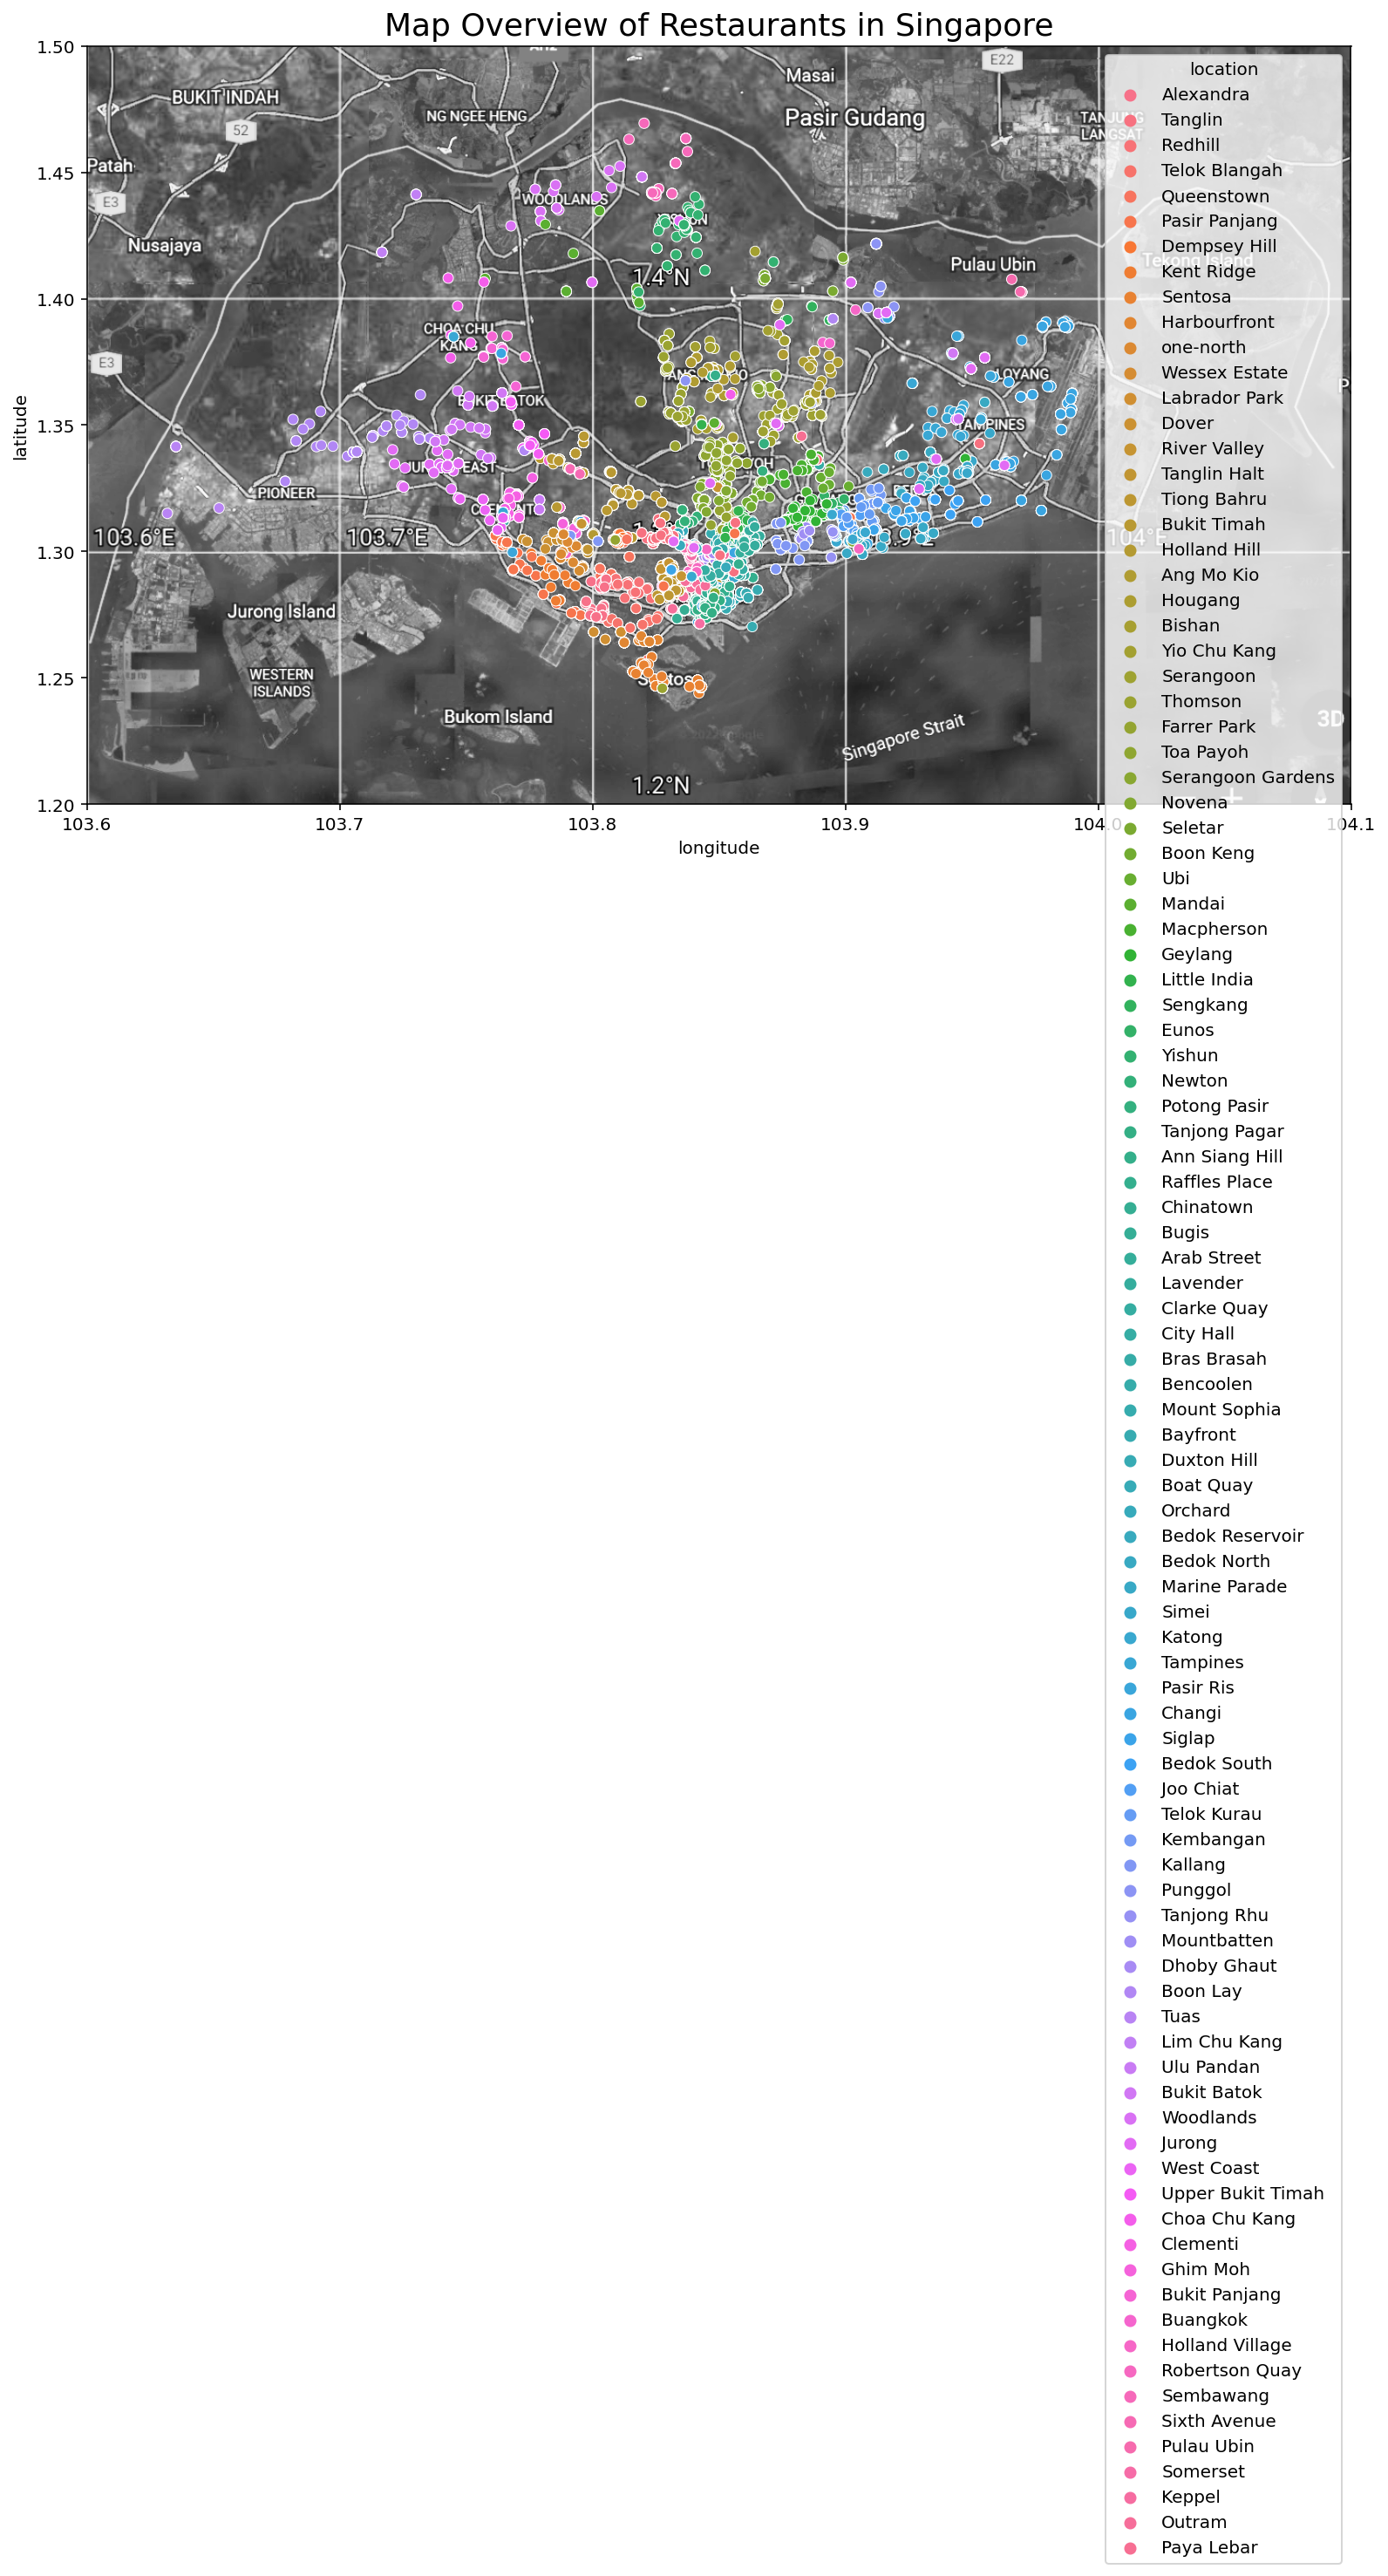

In [9]:
# Plot overview of restaurant locations
plt.figure(figsize=(15,8))
plt.title('Map Overview of Restaurants in Singapore', size=18)
plt.imshow(sg_map_data, 
           cmap=plt.get_cmap('Greys_r'), 
           extent=lon_lat_boundary);
sns.scatterplot(data=df, y='latitude', x='longitude', hue='location');

### Outline of Recommender

1. Location-based Recommender
    - Kmeansmodel
    
2. Collaborative Filtering: This method makes automatic predictions (filtering) about the interests of a user by collecting preferences or taste information from many users (collaborating). The underlying assumption of the collaborative filtering approach is that if a person A has the same opinion as a person B on a set of items, A is more likely to have B's opinion for a given item than that of a randomly chosen person.
    - user-restaurant matrix
    - cosine similarity of matrix

    
3. Content-Based Filtering: This method uses only information about the description and attributes of the items users has previously consumed to model user's preferences. In other words, these algorithms try to recommend items that are similar to those that a user liked in the past (or is examining in the present). In particular, various candidate items are compared with items previously rated by the user and the best-matching items are recommended.
    - bag of words for each restaurants
    - Basic Similarity Matrix based on restaurant and categories
        - cosine similarity (similar restaurants)
    - Profile-Based Recommender (users-users Matrix)
    
4. Machine Learning Model - surprise library (collaborative)
    - Evaluation Metric:
        - RMSE
        - Precision quantifies the number of positive class predictions that actually belong to the positive class. (number of recommended restaurants above the threshold,  mean rating of 3.8, that is also user preference is to all restaurants with predicted rating above 3.8 rating)
        - Recall quantifies the number of positive class predictions made out of all positive examples in the dataset. (number of recommended restaurants above the threshold,  mean rating of 3.8, that is also user preference is to all restaurants that the user prefer, above 3.8 rating)
    - Models
        - NormalPredictor
        - BaselineOnly
        - KNN (base model, with mean user ratings, with normalisation of ratings)
        - Matrix factorisation (SVD)

## 7a.  Location-based Recommender

Group restaurants together based on geographical location is using the K-Means Clustering Algorithm. The K-Means algorithm predicts the cluster where the user is located in and pulls out this cluster’s top 10 restaurants and recommends them to him.

In [10]:
rest_coord_df = df[['rest_name', 'href', 'longitude','latitude']]
rest_coord_df.drop_duplicates(ignore_index=True, inplace=True)
rest_coord_df.head()

rest_name                                               href  \
0        The Naked Finn  http://www.yelp.com/biz/the-naked-finn-singapo...   
1     Soi Thai Soi Nice  http://www.yelp.com/biz/soi-thai-soi-nice-sing...   
2              The Gogi  http://www.yelp.com/biz/the-gogi-singapore?osq...   
3  Keng Eng Kee Seafood  http://www.yelp.com/biz/keng-eng-kee-seafood-s...   
4           Burger Barn  http://www.yelp.com/biz/burger-barn-singapore?...   

    longitude  latitude  
0  103.804434  1.276081  
1  103.805283  1.287283  
2  103.805283  1.287283  
3  103.803532  1.285823  
4  103.801399  1.274149

In [11]:
scores = []

for k in range(2,15):
    kmeansModel = KMeans(n_clusters=k, random_state=42)
    kmeansModel = kmeansModel.fit(rest_coord_df[['longitude','latitude']])
    sil = silhouette_score(rest_coord_df[['longitude','latitude']], kmeansModel.labels_)
    scores.append([k, kmeansModel.inertia_, sil])
    
score_df = pd.DataFrame(scores, 
                        columns=['k', 'inertia', 'silhouette'])

- we calculate the Within-Cluster-Sum of Squared Errors (WSS) for different values of k, and choose the k for which WSS first starts to diminish. In the plot of WSS-versus-k, this is visible as an elbow. Based on the above figure, the optimal k = 7 (clusters).
-  Silhouette Score measures how similar a point is to its own cluster (cohesion) compared to other clusters (separation). The range of the Silhouette value is between +1 and -1. A high value is desirable and indicates that the point is placed in the correct cluster. The Silhouette Score reaches its global maximum at the optimal k. Starting from 2 clusters, the optimal k based on the above Silhouette Scores would be k = 7 (clusters).

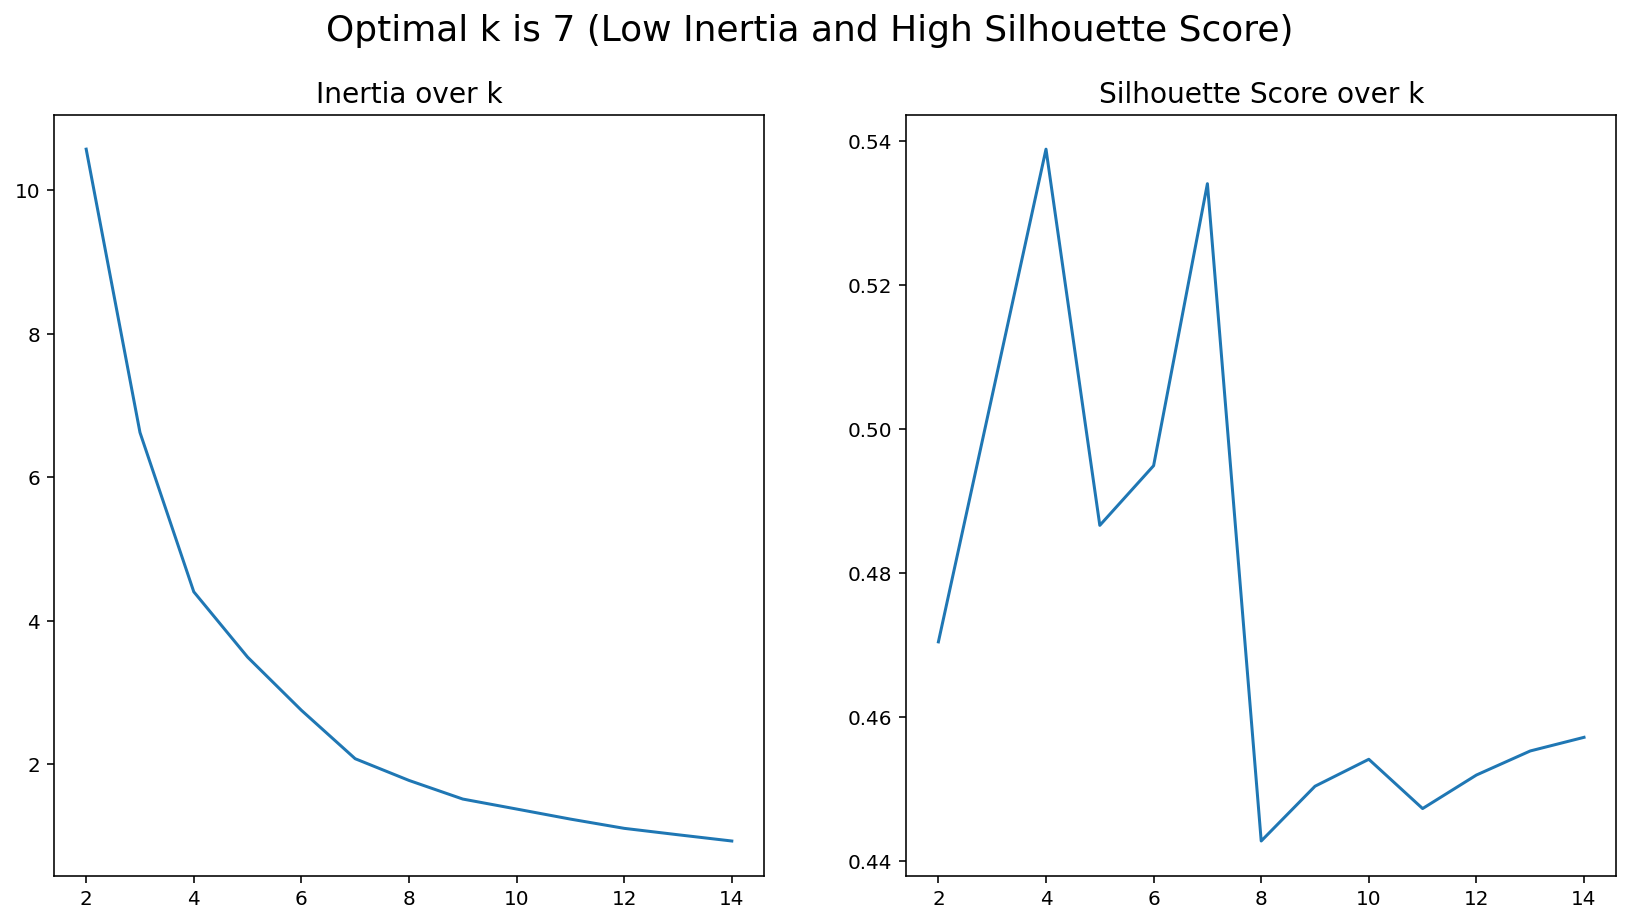

In [12]:
# Graph for WSS
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
plt.suptitle('Optimal k is 7 (Low Inertia and High Silhouette Score)', size=18)
axes[0].plot(score_df.k, score_df.inertia)
axes[0].set_title('Inertia over k', size=14)
axes[1].plot(score_df.k, score_df.silhouette)
axes[1].set_title('Silhouette Score over k', size=14);

In [13]:
# Instantiate and fit kmeansModel
kmeansModel = KMeans(n_clusters=7)
kmeansModel.fit(rest_coord_df[['longitude','latitude']])

print("k = 7")
print("inertia: ", kmeansModel.inertia_)
print("silhouette_score: ", silhouette_score(rest_coord_df[['longitude','latitude']], kmeansModel.labels_))

k = 7
inertia:  2.0773586738000316
silhouette_score:  0.5340725324544607


In [14]:
df['rest_cluster'] = kmeansModel.predict(df[['longitude','latitude']])
df.head(2)

rest_name                                               href  \
0  The Naked Finn  http://www.yelp.com/biz/the-naked-finn-singapo...   
1  The Naked Finn  http://www.yelp.com/biz/the-naked-finn-singapo...   

                                   address postal_code  latitude   longitude  \
0  39 Malan Rd Singapore 109442 Singapore       109442  1.276081  103.804434   
1  39 Malan Rd Singapore 109442 Singapore       109442  1.276081  103.804434   

                                             opening  \
0  [('Mon', ['12:00 PM - 3:00 PM', '6:00 PM - 10:...   
1  [('Mon', ['12:00 PM - 3:00 PM', '6:00 PM - 10:...   

                                                 img  star_rating  \
0  https://s3-media0.fl.yelpcdn.com/bphoto/ScSHvC...          4.5   
1  https://s3-media0.fl.yelpcdn.com/bphoto/ScSHvC...          4.5   

   review_count  ... category_salad  category_delis category_food_court  \
0          19.0  ...              0               0                   0   
1          19.0  ...              0               0                   0   

  category_thai category_dim_sum  category_seafood category_henghwa  \
0             0                0                 1                0   
1             0                0                 1                0   

  category_kopitiam  category_middle_eastern  rest_cluster  
0                 0                        0             5  
1                 0                        0             5  

[2 rows x 194 columns]

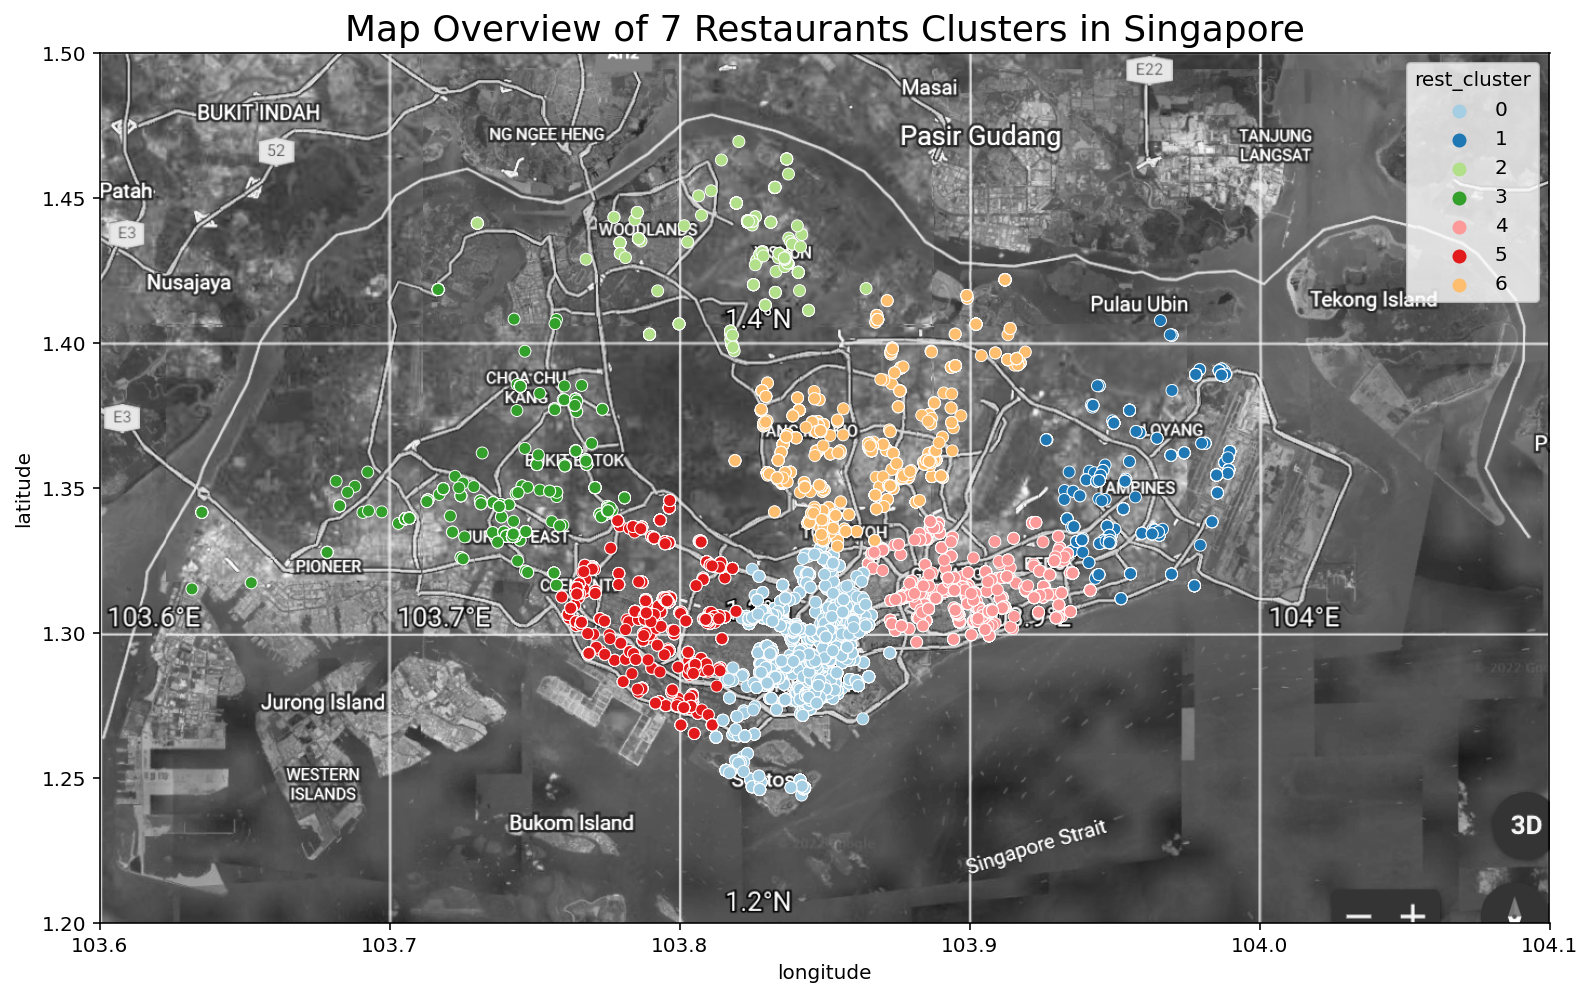

In [15]:
# Geographical Plot of 7 Clusters
plt.figure(figsize=(15,8))
plt.title('Map Overview of 7 Restaurants Clusters in Singapore', size=18)
plt.imshow(sg_map_data, 
           cmap=plt.get_cmap('Greys_r'), 
           extent=lon_lat_boundary);
sns.scatterplot(data=df, y='latitude', x='longitude', hue='rest_cluster', palette='Paired');

Singapore has an area of 729km², the 7 restaurant clusters identified are assessed to be optimal for the Location-Based Recommender, which to recommend restaurants within close proximity to the user's geographical location.

The next step is to recommend restaurants with high ratings, which is likely to enhance user's experience of using the 

Apart from recommending restaurants that are close to a user, it is also important that the recommended restaurannts have a rating that is as high as possible. Restaurants that have an overall higher rating (star) generally translates to better customer experience which will improve user's customer satisfaction of using the Location-Based Recommender.

In [16]:
# Define function to scrape data from url.
def get_soup(url):
    
    # Establishing the connection to the web page:
    res = requests.get(url, stream=True)

    if res.status_code==200:
        return BeautifulSoup(res.content, 'lxml')
        
    else:
        print(f'Res Status Code: {res.status_code}')
        pass

In [190]:
# Define function which recommends top 10 highest rating restaurants
def location_based_recommender(df, postal_code):

    # get latitude and longitude based on postal_code
    onemap = get_soup(f'https://developers.onemap.sg/commonapi/search?searchVal={postal_code}&returnGeom=Y&getAddrDetails=Y&pageNum=1')
    address = json.loads(onemap.p.text)['results'][0]['ADDRESS']
    latitude = round(float(json.loads(onemap.p.text)['results'][0]['LATITUDE']),2)
    longitude = round(float(json.loads(onemap.p.text)['results'][0]['LONGTITUDE']),2)
    loc = pd.DataFrame({'longitude':[longitude],'latitude':[latitude]})
    
    # Predict restaurant cluster which the user is in.
    cluster = kmeansModel.predict(loc)[0]
    print(f"User's location: {address} ({longitude}, {latitude})")
    print("User is in restaurant cluster:", cluster)
   
    # Create dataframe for top 10 highest rated restaurant in this cluster
    top_10_rest_df = df[(df['rest_cluster']==cluster) & (df['review_count']>1)][rest_info_col+['rest_cluster']]
    top_10_rest_df = top_10_rest_df.drop_duplicates(ignore_index=True)
    top_10_rest_df = top_10_rest_df.sort_values(by=['star_rating', 'review_count'], ascending=False).reset_index(drop=True)  
    
    return top_10_rest_df.head(10)[['rest_name','href']], top_10_rest_df, loc

In [332]:
# define function to show restaurant clusters
def plot_rest_cluster(df, loc):
    plt.figure(figsize=(15,8))
    plt.title('Map Overview of 7 Restaurants Clusters in Singapore', size=18)
    plt.imshow(sg_map_data, 
               cmap=plt.get_cmap('Greys_r'), 
               extent=lon_lat_boundary);
    sns.scatterplot(data=df, y='latitude', x='longitude', marker='o')
    sns.scatterplot(data=loc, y='latitude', x='longitude', marker='o');

### Examples

**Example 1**: Postal Code is '079906'.

In [191]:
results, top_10_rest_df, loc = location_based_recommender(df, '079906')
results

User's location: 79 ANSON ROAD SINGAPORE 079906 (103.85, 1.27)
User is in restaurant cluster: 0


rest_name  \
0              Two Men Bagel House   
1           Man Man Japanese Unagi   
2                           Ki-sho   
3            Rhubarb Le Restaurant   
4  Hong Kong Style Chee Cheong Fun   
5                   Meat And Green   
6                 Tandoori Culture   
7                     Neko no Niwa   
8            Sanji Kagoshima Ramen   
9                       Akira Back   

                                                href  
0  http://www.yelp.com/biz/two-men-bagel-house-si...  
1  http://www.yelp.com/biz/man-man-japanese-unagi...  
2  http://www.yelp.com/biz/ki-sho-singapore?osq=R...  
3  http://www.yelp.com/biz/rhubarb-le-restaurant-...  
4  http://www.yelp.com/biz/hong-kong-style-chee-c...  
5  http://www.yelp.com/biz/meat-and-green-singapo...  
6  http://www.yelp.com/biz/tandoori-culture-singa...  
7  http://www.yelp.com/biz/neko-no-niwa-singapore...  
8  http://www.yelp.com/biz/sanji-kagoshima-ramen-...  
9  http://www.yelp.com/biz/akira-back-blackburn?o...

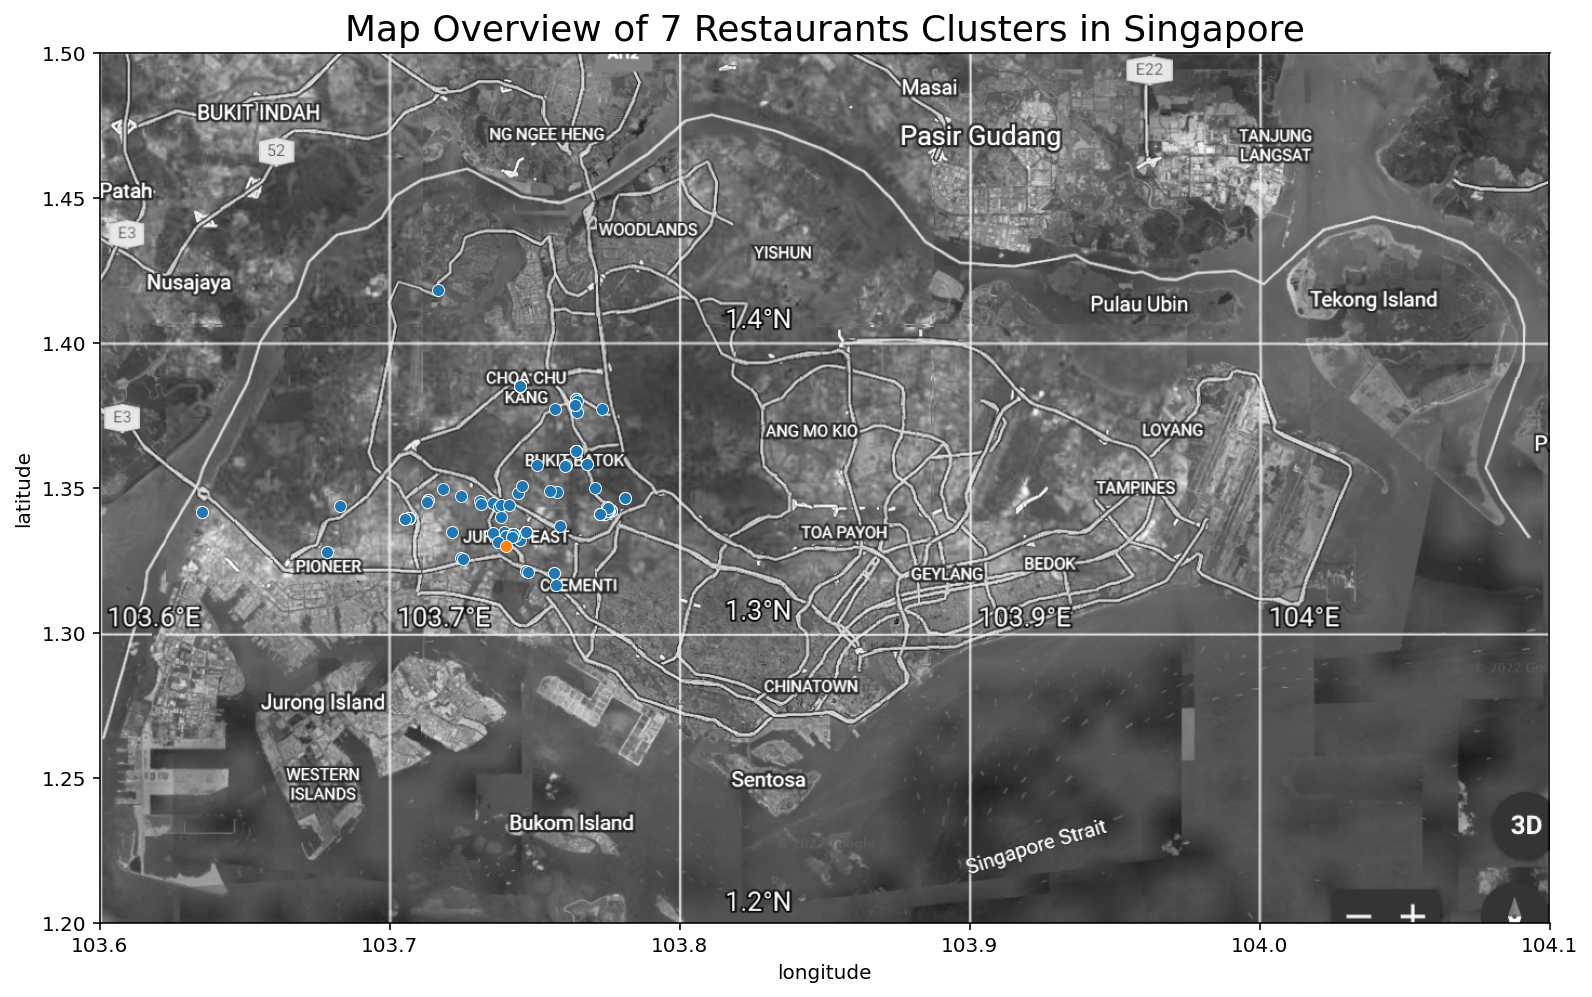

In [333]:
# Show map
plot_rest_cluster(top_10_rest_df, loc)

**Example 2**: Postal Code is '609081'.

In [192]:
results, top_10_rest_df, loc = location_based_recommender(df, '609081')
results

User's location: 15 SCIENCE CENTRE ROAD DBS SINGAPORE SCIENCE CENTRE SINGAPORE 609081 (103.74, 1.33)
User is in restaurant cluster: 3


rest_name  \
0                   Din Tai Fung   
1                   Din Tai Fung   
2              Shokutsu 10-Osaka   
3  Kotoshi Ryori Japanese Dining   
4                   Din Tai Fung   
5                   Din Tai Fung   
6             iO Italian Osteria   
7                 Acqua e Farina   
8                Malaysia Boleh!   
9                Enaq Restaurant   

                                                href  
0  http://www.yelp.com/biz/din-tai-fung-singapore...  
1  http://www.yelp.com/biz/din-tai-fung-singapore...  
2  http://www.yelp.com/biz/shokutsu-10-osaka-sing...  
3  http://www.yelp.com/biz/kotoshi-ryori-japanese...  
4  http://www.yelp.com/biz/din-tai-fung-singapore...  
5  http://www.yelp.com/biz/din-tai-fung-singapore...  
6  http://www.yelp.com/biz/io-italian-osteria-sin...  
7  http://www.yelp.com/biz/acqua-e-farina-singapo...  
8  http://www.yelp.com/biz/malaysia-boleh-singapo...  
9  http://www.yelp.com/biz/enaq-restaurant-singap...

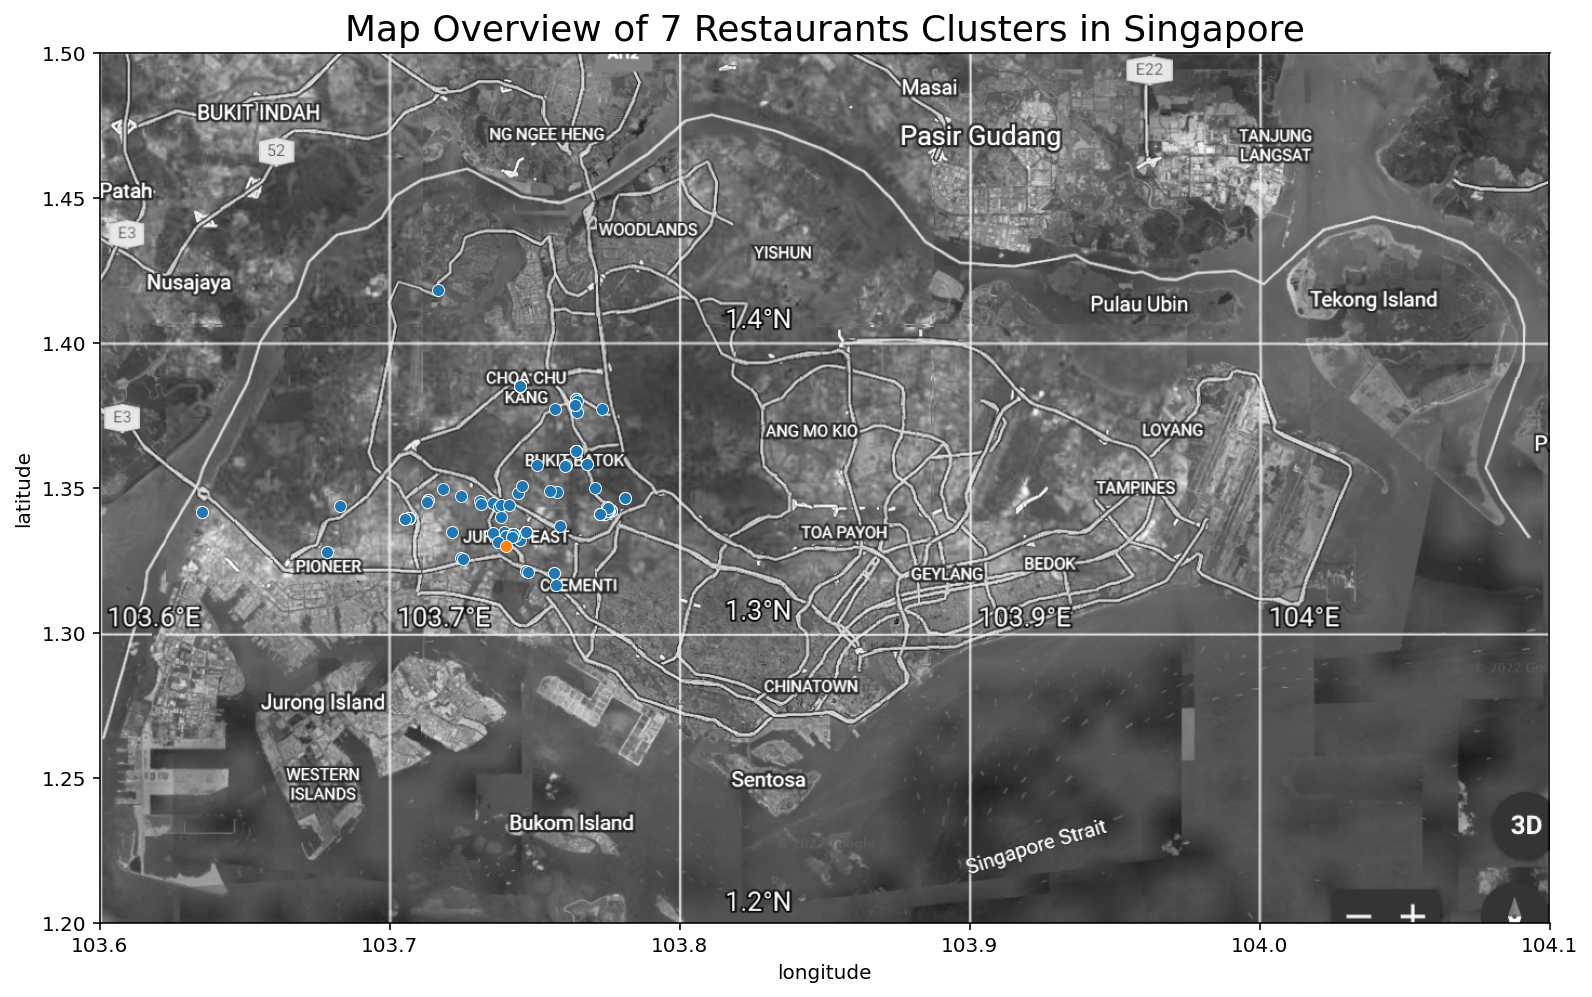

In [166]:
# Show map
plot_rest_cluster(top_10_rest_df, loc)

## 7b. Collaborative-Filtering Recommendation System

Collaborative filtering is a technique that can filter out items that a user might like on the basis of reactions by similar users.

It works by searching a large group of people and finding a smaller set of users with tastes similar to a particular user. It looks at the items they like and combines them to create a ranked list of suggestions.

### (1) Memory based

#### User-based Collaborative Filtering

**User-Item Matrix**

In [20]:
# Create a dataframe of review counts based on users. 
user_base_df = df.groupby(['username', 'userid']).count()[['comment']].sort_values(by='comment', ascending=False)


In [21]:
# For modelling to be meaningful, database based on users with more than 4 comments will be used (refer to EDA). 
user_base_df = user_base_df[user_base_df['comment']>4].reset_index(drop=False)

In [22]:
# There are 999 unique users with more than 4 reviews. 
# there are a total of 16,153 reviews.  
user_base_df.shape[0], user_base_df.sum()

(999,
 username    Doreen T.Ancy N.Melissa Y.Lam N.Carolyn L.Mich...
 userid      2F38Uc4UNNbFVdyUUnBjOA4y4obgWxi_CL25nRHrhuEAH8...
 comment                                                 16153
 dtype: object)

In [23]:
# Display dataframe
user_base_df.head(3)

username                  userid  comment
0   Doreen T.  2F38Uc4UNNbFVdyUUnBjOA      313
1     Ancy N.  4y4obgWxi_CL25nRHrhuEA      183
2  Melissa Y.  H8mXfh5XgGCqmMLwVH7k5A      156

In [24]:
# extract reveiw index for these users. 
review_index = [] 
for userid in user_base_df['userid']:
    review_index.extend(df[df['userid']==userid].index)

In [86]:
df.loc[review_index, :].head(2)

rest_name                                               href  \
1   The Naked Finn  http://www.yelp.com/biz/the-naked-finn-singapo...   
67          Masons  http://www.yelp.com/biz/masons-singapore?osq=R...   

                                           address postal_code  latitude  \
1          39 Malan Rd Singapore 109442 Singapore       109442  1.276081   
67  8 Lock Road #01-17 Singapore 108936 Singapore       108936  1.277710   

     longitude                                            opening  \
1   103.804434  [('Mon', ['12:00 PM - 3:00 PM', '6:00 PM - 10:...   
67  103.804011                                                 []   

                                                  img  star_rating  \
1   https://s3-media0.fl.yelpcdn.com/bphoto/ScSHvC...          4.5   
67  https://s3-media0.fl.yelpcdn.com/bphoto/nD043X...          3.5   

    review_count  ... category_salad  category_delis category_food_court  \
1           19.0  ...              0               0                   0   
67           7.0  ...              0               0                   0   

   category_thai category_dim_sum  category_seafood category_henghwa  \
1              0                0                 1                0   
67             0                0                 0                0   

   category_kopitiam  category_middle_eastern  rest_cluster  
1                  0                        0             5  
67                 0                        0             5  

[2 rows x 194 columns]

In [25]:
# Create matrix dataframe
matrix_df = df.loc[review_index, :]
matrix_df = matrix_df.pivot_table(index = 'userid', 
                                  columns = 'rest_name', 
                                  values = ['user_rating'])

In [26]:
# Display user-item matrix
matrix_df

rest_name               % Arabica  & Why  &Made Burger Bistro  \
userid                                                          
--ZIfEMWxYOXk9PUYibeAw        NaN    NaN                  NaN   
-0D44Oa5eolEFmaIM4MbWA        NaN    NaN                  NaN   
-5YMIME_WEin_by41Bj-3Q        NaN    NaN                  NaN   
-G1YjYxjDpxOBzFgo36ORA        NaN    NaN                  NaN   
-QAk8tXQddkqVVYnhOu1pg        NaN    NaN                  NaN   
...                           ...    ...                  ...   
znaofcTB6CKmdUqJSd17iA        NaN    NaN                  NaN   
zqeOwIpO1a2IUXkU8s1oyg        NaN    NaN                  NaN   
zrT9ajIiHc_wUi-pC77aaQ        NaN    NaN                  NaN   
zrnVqJMsN-2PFfxn0zBkyw        NaN    NaN                  NaN   
zwmNnNkL2bTX5AsSdVs51w        NaN    NaN                  NaN   

rest_name               1 Tyrwhitt Bistro & Bar  1-Caramel at One Rochestor  \
userid                                                                        
--ZIfEMWxYOXk9PUYibeAw                      NaN                         NaN   
-0D44Oa5eolEFmaIM4MbWA                      NaN                         NaN   
-5YMIME_WEin_by41Bj-3Q                      NaN                         NaN   
-G1YjYxjDpxOBzFgo36ORA                      NaN                         NaN   
-QAk8tXQddkqVVYnhOu1pg                      NaN                         NaN   
...                                         ...                         ...   
znaofcTB6CKmdUqJSd17iA                      NaN                         2.0   
zqeOwIpO1a2IUXkU8s1oyg                      NaN                         NaN   
zrT9ajIiHc_wUi-pC77aaQ                      NaN                         NaN   
zrnVqJMsN-2PFfxn0zBkyw                      NaN                         NaN   
zwmNnNkL2bTX5AsSdVs51w                      NaN                         NaN   

rest_name               10 Scotts  10 at Claymore  101 Seafood Gourmet  \
userid                                                                   
--ZIfEMWxYOXk9PUYibeAw        NaN             NaN                  NaN   
-0D44Oa5eolEFmaIM4MbWA        NaN             NaN                  NaN   
-5YMIME_WEin_by41Bj-3Q        NaN             NaN                  NaN   
-G1YjYxjDpxOBzFgo36ORA        NaN             NaN                  NaN   
-QAk8tXQddkqVVYnhOu1pg        NaN             NaN                  NaN   
...                           ...             ...                  ...   
znaofcTB6CKmdUqJSd17iA        NaN             NaN                  NaN   
zqeOwIpO1a2IUXkU8s1oyg        NaN             NaN                  NaN   
zrT9ajIiHc_wUi-pC77aaQ        NaN             NaN                  NaN   
zrnVqJMsN-2PFfxn0zBkyw        NaN             NaN                  NaN   
zwmNnNkL2bTX5AsSdVs51w        NaN             NaN                  NaN   

rest_name               1036 Live Seafood  109 Teochew Yong Tau Foo  ...  \
userid                                                               ...   
--ZIfEMWxYOXk9PUYibeAw                NaN                       NaN  ...   
-0D44Oa5eolEFmaIM4MbWA                NaN                       NaN  ...   
-5YMIME_WEin_by41Bj-3Q                NaN                       NaN  ...   
-G1YjYxjDpxOBzFgo36ORA                NaN                       NaN  ...   
-QAk8tXQddkqVVYnhOu1pg                NaN                       NaN  ...   
...                                   ...                       ...  ...   
znaofcTB6CKmdUqJSd17iA                NaN                       NaN  ...   
zqeOwIpO1a2IUXkU8s1oyg                NaN                       NaN  ...   
zrT9ajIiHc_wUi-pC77aaQ                NaN                       NaN  ...   
zrnVqJMsN-2PFfxn0zBkyw                NaN                       NaN  ...   
zwmNnNkL2bTX5AsSdVs51w                NaN                       NaN  ...   

rest_name               sufood  ta.ke Cafe  the Mind Cafe  timbre @ gillman  \
userid                                                                        
--ZIfEMWxYOXk9PU

In [27]:
# define function to compute mean and normalise users_ratings. 
def mean_center_rows(df):
    return (df.T - df.mean(axis=1)).T

In [28]:
# Compute normalist user_ratings for each user and restaurant. 
matrix_mc = mean_center_rows(matrix_df)

# Display first 5 and last 5 rows of matrix_mc
matrix_mc

rest_name               % Arabica  & Why  &Made Burger Bistro  \
userid                                                          
--ZIfEMWxYOXk9PUYibeAw        NaN    NaN                  NaN   
-0D44Oa5eolEFmaIM4MbWA        NaN    NaN                  NaN   
-5YMIME_WEin_by41Bj-3Q        NaN    NaN                  NaN   
-G1YjYxjDpxOBzFgo36ORA        NaN    NaN                  NaN   
-QAk8tXQddkqVVYnhOu1pg        NaN    NaN                  NaN   
...                           ...    ...                  ...   
znaofcTB6CKmdUqJSd17iA        NaN    NaN                  NaN   
zqeOwIpO1a2IUXkU8s1oyg        NaN    NaN                  NaN   
zrT9ajIiHc_wUi-pC77aaQ        NaN    NaN                  NaN   
zrnVqJMsN-2PFfxn0zBkyw        NaN    NaN                  NaN   
zwmNnNkL2bTX5AsSdVs51w        NaN    NaN                  NaN   

rest_name               1 Tyrwhitt Bistro & Bar  1-Caramel at One Rochestor  \
userid                                                                        
--ZIfEMWxYOXk9PUYibeAw                      NaN                         NaN   
-0D44Oa5eolEFmaIM4MbWA                      NaN                         NaN   
-5YMIME_WEin_by41Bj-3Q                      NaN                         NaN   
-G1YjYxjDpxOBzFgo36ORA                      NaN                         NaN   
-QAk8tXQddkqVVYnhOu1pg                      NaN                         NaN   
...                                         ...                         ...   
znaofcTB6CKmdUqJSd17iA                      NaN                       -1.47   
zqeOwIpO1a2IUXkU8s1oyg                      NaN                         NaN   
zrT9ajIiHc_wUi-pC77aaQ                      NaN                         NaN   
zrnVqJMsN-2PFfxn0zBkyw                      NaN                         NaN   
zwmNnNkL2bTX5AsSdVs51w                      NaN                         NaN   

rest_name               10 Scotts  10 at Claymore  101 Seafood Gourmet  \
userid                                                                   
--ZIfEMWxYOXk9PUYibeAw        NaN             NaN                  NaN   
-0D44Oa5eolEFmaIM4MbWA        NaN             NaN                  NaN   
-5YMIME_WEin_by41Bj-3Q        NaN             NaN                  NaN   
-G1YjYxjDpxOBzFgo36ORA        NaN             NaN                  NaN   
-QAk8tXQddkqVVYnhOu1pg        NaN             NaN                  NaN   
...                           ...             ...                  ...   
znaofcTB6CKmdUqJSd17iA        NaN             NaN                  NaN   
zqeOwIpO1a2IUXkU8s1oyg        NaN             NaN                  NaN   
zrT9ajIiHc_wUi-pC77aaQ        NaN             NaN                  NaN   
zrnVqJMsN-2PFfxn0zBkyw        NaN             NaN                  NaN   
zwmNnNkL2bTX5AsSdVs51w        NaN             NaN                  NaN   

rest_name               1036 Live Seafood  109 Teochew Yong Tau Foo  ...  \
userid                                                               ...   
--ZIfEMWxYOXk9PUYibeAw                NaN                       NaN  ...   
-0D44Oa5eolEFmaIM4MbWA                NaN                       NaN  ...   
-5YMIME_WEin_by41Bj-3Q                NaN                       NaN  ...   
-G1YjYxjDpxOBzFgo36ORA                NaN                       NaN  ...   
-QAk8tXQddkqVVYnhOu1pg                NaN                       NaN  ...   
...                                   ...                       ...  ...   
znaofcTB6CKmdUqJSd17iA                NaN                       NaN  ...   
zqeOwIpO1a2IUXkU8s1oyg                NaN                       NaN  ...   
zrT9ajIiHc_wUi-pC77aaQ                NaN                       NaN  ...   
zrnVqJMsN-2PFfxn0zBkyw                NaN                       NaN  ...   
zwmNnNkL2bTX5AsSdVs51w                NaN                       NaN  ...   

rest_name               sufood  ta.ke Cafe  the Mind Cafe  timbre @ gillman  \
userid                                                                        
--ZIfEMWxYOXk9PU

In [29]:
# Fill Null Values with 0. 
matrix_mc.fillna(0, inplace=True)

# Display first 5 and last 5 rows of matrix_mc
matrix_mc

rest_name               % Arabica  & Why  &Made Burger Bistro  \
userid                                                          
--ZIfEMWxYOXk9PUYibeAw        0.0    0.0                  0.0   
-0D44Oa5eolEFmaIM4MbWA        0.0    0.0                  0.0   
-5YMIME_WEin_by41Bj-3Q        0.0    0.0                  0.0   
-G1YjYxjDpxOBzFgo36ORA        0.0    0.0                  0.0   
-QAk8tXQddkqVVYnhOu1pg        0.0    0.0                  0.0   
...                           ...    ...                  ...   
znaofcTB6CKmdUqJSd17iA        0.0    0.0                  0.0   
zqeOwIpO1a2IUXkU8s1oyg        0.0    0.0                  0.0   
zrT9ajIiHc_wUi-pC77aaQ        0.0    0.0                  0.0   
zrnVqJMsN-2PFfxn0zBkyw        0.0    0.0                  0.0   
zwmNnNkL2bTX5AsSdVs51w        0.0    0.0                  0.0   

rest_name               1 Tyrwhitt Bistro & Bar  1-Caramel at One Rochestor  \
userid                                                                        
--ZIfEMWxYOXk9PUYibeAw                      0.0                        0.00   
-0D44Oa5eolEFmaIM4MbWA                      0.0                        0.00   
-5YMIME_WEin_by41Bj-3Q                      0.0                        0.00   
-G1YjYxjDpxOBzFgo36ORA                      0.0                        0.00   
-QAk8tXQddkqVVYnhOu1pg                      0.0                        0.00   
...                                         ...                         ...   
znaofcTB6CKmdUqJSd17iA                      0.0                       -1.47   
zqeOwIpO1a2IUXkU8s1oyg                      0.0                        0.00   
zrT9ajIiHc_wUi-pC77aaQ                      0.0                        0.00   
zrnVqJMsN-2PFfxn0zBkyw                      0.0                        0.00   
zwmNnNkL2bTX5AsSdVs51w                      0.0                        0.00   

rest_name               10 Scotts  10 at Claymore  101 Seafood Gourmet  \
userid                                                                   
--ZIfEMWxYOXk9PUYibeAw        0.0             0.0                  0.0   
-0D44Oa5eolEFmaIM4MbWA        0.0             0.0                  0.0   
-5YMIME_WEin_by41Bj-3Q        0.0             0.0                  0.0   
-G1YjYxjDpxOBzFgo36ORA        0.0             0.0                  0.0   
-QAk8tXQddkqVVYnhOu1pg        0.0             0.0                  0.0   
...                           ...             ...                  ...   
znaofcTB6CKmdUqJSd17iA        0.0             0.0                  0.0   
zqeOwIpO1a2IUXkU8s1oyg        0.0             0.0                  0.0   
zrT9ajIiHc_wUi-pC77aaQ        0.0             0.0                  0.0   
zrnVqJMsN-2PFfxn0zBkyw        0.0             0.0                  0.0   
zwmNnNkL2bTX5AsSdVs51w        0.0             0.0                  0.0   

rest_name               1036 Live Seafood  109 Teochew Yong Tau Foo  ...  \
userid                                                               ...   
--ZIfEMWxYOXk9PUYibeAw                0.0                       0.0  ...   
-0D44Oa5eolEFmaIM4MbWA                0.0                       0.0  ...   
-5YMIME_WEin_by41Bj-3Q                0.0                       0.0  ...   
-G1YjYxjDpxOBzFgo36ORA                0.0                       0.0  ...   
-QAk8tXQddkqVVYnhOu1pg                0.0                       0.0  ...   
...                                   ...                       ...  ...   
znaofcTB6CKmdUqJSd17iA                0.0                       0.0  ...   
zqeOwIpO1a2IUXkU8s1oyg                0.0                       0.0  ...   
zrT9ajIiHc_wUi-pC77aaQ                0.0                       0.0  ...   
zrnVqJMsN-2PFfxn0zBkyw                0.0                       0.0  ...   
zwmNnNkL2bTX5AsSdVs51w                0.0                       0.0  ...   

rest_name               sufood  ta.ke Cafe  the Mind Cafe  timbre @ gillman  \
userid                                                                        
--ZIfEMWxYOXk9PU

In [30]:
# Get similarity between users
user_sim_matrix = cosine_similarity(matrix_mc)
users_sim = pd.DataFrame(user_sim_matrix, columns=matrix_mc.index, index=matrix_mc.index)
users_sim.iloc[:10, :10]

userid                  --ZIfEMWxYOXk9PUYibeAw  -0D44Oa5eolEFmaIM4MbWA  \
userid                                                                   
--ZIfEMWxYOXk9PUYibeAw                     1.0                     0.0   
-0D44Oa5eolEFmaIM4MbWA                     0.0                     1.0   
-5YMIME_WEin_by41Bj-3Q                     0.0                     0.0   
-G1YjYxjDpxOBzFgo36ORA                     0.0                     0.0   
-QAk8tXQddkqVVYnhOu1pg                     0.0                     0.0   
-R30cfDhWG9-_8sfHU1IHw                     0.0                     0.0   
-WShM_YFbtG4OcE0vrFVyw                     0.0                     0.0   
-X9wJkeQfWIL-qV6QTIh5g                     0.0                     0.0   
-XaIf12ricWc5z5BRt9nnQ                     0.0                     0.0   
-fUWq6sOIEe1uTUhNKS9sQ                     0.0                     0.0   

userid                  -5YMIME_WEin_by41Bj-3Q  -G1YjYxjDpxOBzFgo36ORA  \
userid                                                                   
--ZIfEMWxYOXk9PUYibeAw                     0.0                0.000000   
-0D44Oa5eolEFmaIM4MbWA                     0.0                0.000000   
-5YMIME_WEin_by41Bj-3Q                     1.0                0.000000   
-G1YjYxjDpxOBzFgo36ORA                     0.0                1.000000   
-QAk8tXQddkqVVYnhOu1pg                     0.0                0.000000   
-R30cfDhWG9-_8sfHU1IHw                     0.0                0.000000   
-WShM_YFbtG4OcE0vrFVyw                     0.0               -0.014298   
-X9wJkeQfWIL-qV6QTIh5g                     0.0                0.000000   
-XaIf12ricWc5z5BRt9nnQ                     0.0                0.000000   
-fUWq6sOIEe1uTUhNKS9sQ                     0.0                0.000000   

userid                  -QAk8tXQddkqVVYnhOu1pg  -R30cfDhWG9-_8sfHU1IHw  \
userid                                                                   
--ZIfEMWxYOXk9PUYibeAw                     0.0                     0.0   
-0D44Oa5eolEFmaIM4MbWA                     0.0                     0.0   
-5YMIME_WEin_by41Bj-3Q                     0.0                     0.0   
-G1YjYxjDpxOBzFgo36ORA                     0.0                     0.0   
-QAk8tXQddkqVVYnhOu1pg                     0.0                     0.0   
-R30cfDhWG9-_8sfHU1IHw                     0.0                     1.0   
-WShM_YFbtG4OcE0vrFVyw                     0.0                     0.0   
-X9wJkeQfWIL-qV6QTIh5g                     0.0                     0.0   
-XaIf12ricWc5z5BRt9nnQ                     0.0                     0.0   
-fUWq6sOIEe1uTUhNKS9sQ                     0.0                     0.0   

userid                  -WShM_YFbtG4OcE0vrFVyw  -X9wJkeQfWIL-qV6QTIh5g  \
userid                                                                   
--ZIfEMWxYOXk9PUYibeAw                0.000000                     0.0   
-0D44Oa5eolEFmaIM4MbWA                0.000000                     0.0   
-5YMIME_WEin_by41Bj-3Q                0.000000                     0.0   
-G1YjYxjDpxOBzFgo36ORA               -0.014298                     0.0   
-QAk8tXQddkqVVYnhOu1pg                0.000000                     0.0   
-R30cfDhWG9-_8sfHU1IHw                0.000000                     0.0   
-WShM_YFbtG4OcE0vrFVyw                1.000000                     0.0   
-X9wJkeQfWIL-qV6QTIh5g                0.000000                     1.0   
-XaIf12ricWc5z5BRt9nnQ                0.000000                     0.0   
-fUWq6sOIEe1uTUhNKS9sQ                0.000000                     0.0   

userid                  -XaIf12ricWc5z5BRt9nnQ  -fUWq6sOIEe1uTUhNKS9sQ  
userid                                                                  
--ZIfEMWxYOXk9PUYibeAw                     0.0                     0.0  
-0D44Oa5eolEFmaIM4MbWA                     0.0                     0.0  
-5YMIME_WEin_by41Bj-3Q                     0.0                     0.0  
-G1YjYxjDpxOBzFgo36ORA                     0.0                     0.0  
-QAk8t

In [31]:
user_indices = pd.Series(matrix_mc.index)
user_indices[:5]

0    --ZIfEMWxYOXk9PUYibeAw
1    -0D44Oa5eolEFmaIM4MbWA
2    -5YMIME_WEin_by41Bj-3Q
3    -G1YjYxjDpxOBzFgo36ORA
4    -QAk8tXQddkqVVYnhOu1pg
Name: userid, dtype: object

In [32]:
# Define function that input userid and returns the top 10 similar users
def top_similar_users(userid, cosine_sim=user_sim_matrix):
    
    similar_users = []
    
    # gettin the index of the restaurant that matches the title
    idx = user_indices[user_indices == userid].index[0]

    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)

    # getting the indexes of the 10 most similar restaurants
    top_10_indexes = list(score_series.iloc[1:11].index)
    
    # populating the list with the titles of the best 10 matching restaurants
    for i in top_10_indexes:
        similar_users.append(list(matrix_mc.index)[i])
        
    return similar_users

In [33]:
def get_rest_set(similar_users):

    recommended_rest_set = set()
    count = 0

    for user in similar_users:
        temp_set = set(
            df[(df['userid'] == user) 
               & (df['user_rating']>3.8)].set_index(['rest_name','href']).index
        )
        count += len(temp_set)
        recommended_rest_set |= temp_set
    
    return recommended_rest_set

##### Examples

**Example 1** <br>
For `userid` - G1YjYxjDpxOBzFgo36ORA:

In [125]:
# tell the story what he likes and dont. background of this user. 

In [34]:
user_indices[3]

'-G1YjYxjDpxOBzFgo36ORA'

In [35]:
similar_users = top_similar_users(user_indices[3], user_sim_matrix)
similar_users

['ncIHRw4Vx3Wh9mZhLZxB7g',
 'yVx0rLOJHIyPo_Uz0fV9tg',
 'Nv_gr_ujHLRQ8_y0MjfKnw',
 'Dy21CGlNTRyL8GfVAwOy-w',
 'lOE6AUXA6f5HpzIIX5s-1g',
 '0jmAZwCwQN9ByyWsLx7khA',
 'YJyVBqo9enL7XnzMnAkv_A',
 '8Stq_lmhHw8Gt459P_4c7g',
 'kxrZ09KMv9KUDS7NZe2AZQ',
 'SBVNVima7JWeA-6TXVvJbw']

In [36]:
rest_set = get_rest_set(similar_users)
list(rest_set)[:10]

[('The Curry Culture',
  'http://www.yelp.com/biz/the-curry-culture-singapore?osq=Restaurants'),
 ('Brasserie Gavroche',
  'http://www.yelp.com/biz/brasserie-gavroche-singapore?osq=Restaurants'),
 ('Buona Terra',
  'http://www.yelp.com/biz/buona-terra-singapore?osq=Restaurants'),
 ('Living Cafe & Deli',
  'http://www.yelp.com/biz/living-cafe-and-deli-singapore?osq=Restaurants'),
 ('Penang Place',
  'http://www.yelp.com/biz/penang-place-singapore-3?osq=Restaurants'),
 ('Piedra Negra',
  'http://www.yelp.com/biz/piedra-negra-singapore?osq=Restaurants'),
 ('Ya Kun Kaya Toast',
  'http://www.yelp.com/biz/ya-kun-kaya-toast-singapore-10?osq=Restaurants'),
 ('Elemen', 'http://www.yelp.com/biz/elemen-singapore?osq=Restaurants'),
 ('Joie By Dozo',
  'http://www.yelp.com/biz/joie-by-dozo-singapore?osq=Restaurants'),
 ('Bangkok Jam',
  'http://www.yelp.com/biz/bangkok-jam-singapore-4?osq=Restaurants')]

#### Item-based Collaborative Filtering

In [37]:
# Define restaurant columns to be used to get restaurant similarity
col = ['rest_name','href','price_range', 'star_rating', 'review_count', 'rest_cluster']+cat_col

In [38]:
# prepare dataframe to be used to get restaurant similarity
rest_info_df = df.loc[:,col]
rest_info_df = rest_info_df.drop_duplicates(subset='href').reset_index(drop=True)
rest_info_df = rest_info_df.set_index(['rest_name','href'])
rest_info_df

price_range  \
rest_name                    href                                                              
The Naked Finn               http://www.yelp.com/biz/the-naked-finn-singapor...          3.0   
Soi Thai Soi Nice            http://www.yelp.com/biz/soi-thai-soi-nice-singa...          0.0   
The Gogi                     http://www.yelp.com/biz/the-gogi-singapore?osq=...          0.0   
Keng Eng Kee Seafood         http://www.yelp.com/biz/keng-eng-kee-seafood-si...          2.0   
Burger Barn                  http://www.yelp.com/biz/burger-barn-singapore?o...          1.0   
...                                                                                      ...   
Al Malik                     http://www.yelp.com/biz/al-malik-singapore?osq=...          0.0   
Yureka Teppanyaki Restaurant http://www.yelp.com/biz/yureka-teppanyaki-resta...          0.0   
Wadori Yakitori              http://www.yelp.com/biz/wadori-yakitori-singapo...          0.0   
Thai Hao Chi Mookata         http://www.yelp.com/biz/thai-hao-chi-mookata-si...          2.0   
Seoul Jjimdak                http://www.yelp.com/biz/seoul-jjimdak-singapore...          0.0   

                                                                                 star_rating  \
rest_name                    href                                                              
The Naked Finn               http://www.yelp.com/biz/the-naked-finn-singapor...          4.5   
Soi Thai Soi Nice            http://www.yelp.com/biz/soi-thai-soi-nice-singa...          4.5   
The Gogi                     http://www.yelp.com/biz/the-gogi-singapore?osq=...          5.0   
Keng Eng Kee Seafood         http://www.yelp.com/biz/keng-eng-kee-seafood-si...          4.0   
Burger Barn                  http://www.yelp.com/biz/burger-barn-singapore?o...          4.0   
...                                                                                      ...   
Al Malik                     http://www.yelp.com/biz/al-malik-singapore?osq=...          5.0   
Yureka Teppanyaki Restaurant http://www.yelp.com/biz/yureka-teppanyaki-resta...          4.0   
Wadori Yakitori              http://www.yelp.com/biz/wadori-yakitori-singapo...          2.0   
Thai Hao Chi Mookata         http://www.yelp.com/biz/thai-hao-chi-mookata-si...          5.0   
Seoul Jjimdak                http://www.yelp.com/biz/seoul-jjimdak-singapore...          3.5   

                                                                                 review_count  \
rest_name                    href                                                               
The Naked Finn               http://www.yelp.com/biz/the-naked-finn-singapor...          19.0   
Soi Thai Soi Nice            http://www.yelp.com/biz/soi-thai-soi-nice-singa...           2.0   
The Gogi                     http://www.yelp.com/biz/the-gogi-singapore?osq=...           1.0   
Keng Eng Kee Seafood         http://www.yelp.com/biz/keng-eng-kee-seafood-si...          22.0   
Burger Barn                  http://www.yelp.com/biz/burger-barn-singapore?o...           4.0   
...                                                                                       ...   
Al Malik                     http://www.yelp.com/biz/al-malik-singapore?osq=...           1.0   
Yureka Teppanyaki Restaurant http://www.yelp.com/biz/yureka-teppanyaki-resta...           1.0   
Wadori Yakitori              http://www.yelp.com/biz/wadori-yakitori-singapo...           1.0   
Thai Hao Chi Mookata         http://www.yelp.com/biz/thai-hao-chi-mookata-si...           1.0   
Seoul Jjimdak                http://www.yelp.com/biz/seoul-jjimdak-singapore...           3.0   

                                                                                 rest_cluster  \
rest_name                    href                                                               
The Naked Finn               http://www.yelp.com/biz/the-naked-finn-singapor...             5   
Soi Thai Soi Nice            h

In [39]:
# formulate restaurant similarity matrix
rest_sim_matrix = cosine_similarity(rest_info_df, rest_info_df)
rest_sim_matrix.shape

(3941, 3941)

In [40]:
# Display restaurant similarity in dataframe.
rest_sim = pd.DataFrame(rest_sim_matrix, columns=rest_info_df.index, index=rest_info_df.index)
rest_sim

rest_name                                                                                                                         The Naked Finn  \
href                                                                            http://www.yelp.com/biz/the-naked-finn-singapore?osq=Restaurants   
rest_name                    href                                                                                                                  
The Naked Finn               http://www.yelp.com/biz/the-naked-finn-singapor...                                           1.000000                 
Soi Thai Soi Nice            http://www.yelp.com/biz/soi-thai-soi-nice-singa...                                           0.575624                 
The Gogi                     http://www.yelp.com/biz/the-gogi-singapore?osq=...                                           0.447720                 
Keng Eng Kee Seafood         http://www.yelp.com/biz/keng-eng-kee-seafood-si...                                           0.996393                 
Burger Barn                  http://www.yelp.com/biz/burger-barn-singapore?o...                                           0.778497                 
...                                                                                                                            ...                 
Al Malik                     http://www.yelp.com/biz/al-malik-singapore?osq=...                                           0.447946                 
Yureka Teppanyaki Restaurant http://www.yelp.com/biz/yureka-teppanyaki-resta...                                           0.491145                 
Wadori Yakitori              http://www.yelp.com/biz/wadori-yakitori-singapo...                                           0.588988                 
Thai Hao Chi Mookata         http://www.yelp.com/biz/thai-hao-chi-mookata-si...                                           0.463329                 
Seoul Jjimdak                http://www.yelp.com/biz/seoul-jjimdak-singapore...                                           0.791637                 

rest_name                                                                                                                         Soi Thai Soi Nice  \
href                                                                            http://www.yelp.com/biz/soi-thai-soi-nice-singapore?osq=Restaurants   
rest_name                    href                                                                                                                     
The Naked Finn               http://www.yelp.com/biz/the-naked-finn-singapor...                                           0.575624                    
Soi Thai Soi Nice            http://www.yelp.com/biz/soi-thai-soi-nice-singa...                                           1.000000                    
The Gogi                     http://www.yelp.com/biz/the-gogi-singapore?osq=...                                           0.959178                    
Keng Eng Kee Seafood         http://www.yelp.com/biz/keng-eng-kee-seafood-si...                                           0.533106                    
Burger Barn                  http://www.yelp.com/biz/burger-barn-singapore?o...                                           0.936647                    
...                                                                                                                            ...                    
Al Malik                     http://www.yelp.com/biz/al-malik-singapore?osq=...                                           0.847216                    
Yureka Teppanyaki Restaurant http://www.yelp.com/biz/yureka-teppanyaki-resta...                                           0.902281                    
Wadori Yakitori              http://www.yelp.com/biz/wadori-yakitori-singapo...                                           0.936809                    
Thai Hao Chi Mookata         http://www.yelp.com/biz/thai-hao-chi-mookata-si...                                    

In [41]:
# Create restaurant indices for recommender to filter recommended similar restaurants
rest_indices = pd.Series(list(zip(*rest_info_df.index))[0])
rest_indices[:5]

0          The Naked Finn
1       Soi Thai Soi Nice
2                The Gogi
3    Keng Eng Kee Seafood
4             Burger Barn
dtype: object

In [42]:
# Define function that input restaurant href and returns the top 10 recommended restaurants
def item_based_recommender(name, cosine_sim):
    
    recommended_restaurants = []
    
    # gettin the index of the restaurant that matches the name
    idx = rest_indices[rest_indices == name].index[0]

    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)

    # getting the indexes of the 10 most similar restaurants
    top_10_indexes = list(score_series.iloc[1:11].index)
    
    # populating the list with the titles of the best 10 matching restaurants
    for i in top_10_indexes:
        recommended_restaurants.append(list(rest_info_df.index)[i])
        
    return recommended_restaurants

##### Examples

**Example 1** <br>
For `rest_name` - Jumbo Seafood:

In [43]:
item_based_recommender('Jumbo Seafood', rest_sim_matrix)

[('CÉ LA VI Restaurant',
  'http://www.yelp.com/biz/c%C3%A9-la-vi-restaurant-marina?osq=Restaurants'),
 ('Liao Fan Hawker Chan',
  'http://www.yelp.com/biz/liao-fan-hawker-chan-singapore-3?osq=Restaurants'),
 ('Song Fa Bak Kut Teh',
  'http://www.yelp.com/biz/song-fa-bak-kut-teh-singapore-11?osq=Restaurants'),
 ('Tian Tian Hainanese Chicken Rice',
  'http://www.yelp.com/biz/tian-tian-hainanese-chicken-rice-singapore-7?osq=Restaurants'),
 ('Din Tai Fung',
  'http://www.yelp.com/biz/din-tai-fung-singapore-5?osq=Restaurants'),
 ('Vatos Urban Tacos',
  'http://www.yelp.com/biz/vatos-urban-tacos-singapore?osq=Restaurants'),
 ('Zam Zam Restaurant',
  'http://www.yelp.com/biz/zam-zam-restaurant-singapore?osq=Restaurants'),
 ('Wild Honey',
  'http://www.yelp.com/biz/wild-honey-singapore-3?osq=Restaurants'),
 ('Tai Hwa Pork Noodle',
  'http://www.yelp.com/biz/tai-hwa-pork-noodle-singapore?osq=Restaurants'),
 ('Ippudo', 'http://www.yelp.com/biz/ippudo-singapore-3?osq=Restaurants')]

### (2) Model based

#### Formulate Database for Modelling

In [44]:
# Create dataframe to be used for 
model_df = df.loc[review_index, ['userid', 'href', 'user_rating']]

In [45]:
# Instantiating the classes

# reader = Reader(line_format="user item rating", rating_scale=(0, 5))   # User/Item/Rating
reader = Reader()
user_data = Dataset.load_from_df(model_df, reader)                   # Reading in df_user_reviews
raw_user_ratings = user_data.raw_ratings

In [46]:
# verify user_data
user_data

In [47]:
#display raw user rating. 
raw_user_ratings[:3]

[('2F38Uc4UNNbFVdyUUnBjOA',
  'http://www.yelp.com/biz/the-naked-finn-singapore?osq=Restaurants',
  4.0,
  None),
 ('2F38Uc4UNNbFVdyUUnBjOA',
  'http://www.yelp.com/biz/masons-singapore?osq=Restaurants',
  4.0,
  None),
 ('2F38Uc4UNNbFVdyUUnBjOA',
  'http://www.yelp.com/biz/tokyo-joe-singapore?osq=Restaurants',
  4.0,
  None)]

#### Train-Test Split Data

In [48]:
# Shuffle raw user rating array
random.Random(42).shuffle(raw_user_ratings)

In [49]:
# Train/test split at 80/20 ratio
total_reviews = len(raw_user_ratings)
split = int(0.7*total_reviews)
train = raw_user_ratings[:split]
test = raw_user_ratings[split:]
print(f'Total number of reviews: {total_reviews}')
print(f'Split at index: {split}')

Total number of reviews: 16153
Split at index: 11307


#### Define Function to Automate Modelling

In [50]:
def modelling_basic(model_name, model, pipe_params, k_num, rating_threshold):
    
    # model_name is a string to label model. 
    # model refers to the model from surprise library to be used
    # pipe params are the parameters to input for GridSerchCV
    # k_num refers to the top k restaurants from predictions
    # rating_threshold refers to the rating, which a restaurant is considered be recommended.
    
    # input random seed
    np.random.seed(42)
    
    # Instantiate dict to store results
    results = {}
    
    # ============== GridSearchCV for Best Params ================
    
    # Define grid search
    gs = GridSearchCV(model,
                      param_grid = pipe_params,
                      cv = 5,
                      measures=[u'rmse'])
    
    # Fitting GridSearchCV
    print('Fitting GridSearchCV...')
    gs.fit(user_data)
    
    # Get GS best score
    cross_val_score = round(gs.best_score['rmse'], 3)
    
    # Get GS best params
    best_params = gs.best_params['rmse']
    
    # Defining the training and test dataset
    user_data.raw_ratings = train  # The "data" is now set to the training set
    trainset = user_data.build_full_trainset()
    
    # Fit best estimator with trainset
    best_model = gs.best_estimator['rmse'].fit(trainset)
    
    
    # ============== Compute RMSE ================
    
    # Compute RMSE on train dataset
    train_predictions = best_model.test(trainset.build_testset())
    train_rmse = round(accuracy.rmse(train_predictions, verbose=False), 3)
    
    # Compute RMSE on the test dataset
    testset = user_data.construct_testset(test)   # The "data" is now set to the test set
    test_predictions = best_model.test(testset)
    test_rmse = round(accuracy.rmse(test_predictions, verbose=False), 3)

    
    # ============== Compute Precision and Recall ================
    # Mapping the predictions to each user.
    true_user_estimates = defaultdict(list)
    
    # A prediction dataset has 5 values
    # uid=raw_user_id, iid=raw_item_id, r_ui=true_rating, 
    # est=estimated_rating, details=additional_useful_info
    for uid, iid, r_ui, est, details in test_predictions:
        
        # Appends estimated and true rating for each user
        true_user_estimates[uid].append((est, r_ui))   
    
    # Creaing a dictionary to store the precision and recall values
    precisions = {}
    recalls = {}
    
    for uid, user_ratings in true_user_estimates.items():

        # Sort user's estimated ratings from highest to lowest
        user_ratings.sort(key=lambda tup: tup[0], reverse=True)

        # Number of relevant items (i.e., true rating greater than threshold)
        num_relevant = sum((r_ui >= rating_threshold) for (_, r_ui) in user_ratings)

        # Number of recommended items in top k
        num_rec_k = sum((est >= rating_threshold) for (est, _) in user_ratings[:k_num])

        # Number of relevant and recommended items in top k
        num_relevant_rec_k = sum(((r_ui >= rating_threshold) and (est >= rating_threshold)) 
                                 for (est, r_ui) in user_ratings[:k_num])

        # Precision@K (i.e. Percentage of recommended items which are relevant)
        # Stores values in dictionary
        precisions[uid] = (num_relevant_rec_k / num_rec_k) if num_rec_k != 0 else 0

        # Recall@K (i.e. Percentage of relevant items that are recommended)
        # Stores values in dictionary
        recalls[uid] = (num_relevant_rec_k / num_relevant) if num_relevant != 0 else 0

    # Calculating the average precision and recall across all users
    precision_all_users = sum(x for x in precisions.values()) / len(precisions)
    recall_all_users = sum(x for x in recalls.values()) / len(recalls)
   
    # Store results
    results['model_name'] = model_name
    results['best_params'] = best_params
    results['train_cross_val_rmse'] = cross_val_score
    results['train_rmse'] = train_rmse
    results['test_rmse'] = test_rmse
    results['average_model_precision'] = round(precision_all_users, 3)
    results['average_model_recall'] = round(recall_all_users, 3)
    
    # Convert results to a dataframe
    temp_df = pd.DataFrame(data=results.values()).T
    results = temp_df.rename(columns=dict(zip(temp_df.columns, results.keys())))

    # Store results in model_summary
    global model_summary
    model_summary = pd.concat([model_summary, results], ignore_index=True)
    
    # Output the calculated values
    print("=======================================================")
    print(f"Best parameters for model:\n{best_params}")
    print("=======================================================")
    print(f"The 5-fold cross validation mean RMSE scores is:\n{cross_val_score}")
    print("=======================================================")
    print(f"The model's RMSE on train data is: {train_rmse}")
    print(f"The model's RMSE on test data is: {test_rmse}")
    print("=======================================================")
    print(f"The average precision for all users is: {round(precision_all_users, 3)}")
    print(f"The average recall for all users is: {round(recall_all_users, 3)}")
    print("=======================================================")
    
    return gs.best_estimator['rmse']

#### (a) NormalPredictor model

In [51]:
# Instantiate dataframe to store model summary. 
# global model_summary 
model_summary = pd.DataFrame()

In [52]:
# Get results for Normal Predictor
normal_predictor = modelling_basic(
    model_name='normal_predictor', 
    model=NormalPredictor, 
    pipe_params={}, 
    k_num=10, 
    rating_threshold=3.8
)

Fitting GridSearchCV...
Best parameters for model:
{}
The 5-fold cross validation mean RMSE scores is:
1.262
The model's RMSE on train data is: 1.264
The model's RMSE on test data is: 1.256
The average precision for all users is: 0.584
The average recall for all users is: 0.457


#### (b) BaselineOnly model

In [53]:
# Configure pipeline
base_pipe_params = {'bsl_options': {'reg': [0.05], #, 0.1, 0.15, 0.2], 
                                    'learning_rate':[0.05], #, 0.1, 0.15, 0.2],
                                    'n_epochs':[50]}, #, 100, 150, 200]},
                    'verbose': [False]}

In [54]:
# Get results for Normal Predictor
baselineonly = modelling_basic(
    model_name='baselineonly', 
    model=BaselineOnly, 
    pipe_params=base_pipe_params, 
    k_num=10, 
    rating_threshold=3.8
)

Fitting GridSearchCV...
Best parameters for model:
{'bsl_options': {'reg': 0.05, 'learning_rate': 0.05, 'n_epochs': 50}, 'verbose': False}
The 5-fold cross validation mean RMSE scores is:
0.887
The model's RMSE on train data is: 0.801
The model's RMSE on test data is: 0.88
The average precision for all users is: 0.621
The average recall for all users is: 0.571


#### (c) KNN Basic model

In [55]:
# Configure pipeline
knn_b_pipe_params = {
    'k': [5], # 3, 5, 7, 9],
    'min_k': [3], # 1, 2, 3],
    'bsl_options': {'reg': [0.05], # , 0.1, 0.15, 0.2], 
                    'learning_rate':[0.05], #, 0.1, 0.15, 0.2],
                    'n_epochs':[50]}, #, 100, 150, 200]},
    'sim_options': {'name': ['msd'], 
                    'user_based': [True]},
    'verbose': [False]
}

In [56]:
# Get results for Normal Predictor
knn_basic = modelling_basic(
    model_name='knn_basic', 
    model=KNNBasic, 
    pipe_params=knn_b_pipe_params, 
    k_num=10, 
    rating_threshold=3.8
)

Fitting GridSearchCV...
Best parameters for model:
{'k': 5, 'min_k': 3, 'bsl_options': {'reg': 0.05, 'learning_rate': 0.05, 'n_epochs': 50}, 'sim_options': {'name': 'msd', 'user_based': True}, 'verbose': False}
The 5-fold cross validation mean RMSE scores is:
0.923
The model's RMSE on train data is: 0.512
The model's RMSE on test data is: 0.923
The average precision for all users is: 0.719
The average recall for all users is: 0.802


#### (d) KNN with Means model

In [57]:
# Configure pipeline
knn_m_pipe_params = {
    'k': [7], # 3, 5, 7, 9],
    'min_k': [3], #1, 2, 3],
    'bsl_options': {'reg': [0.05], #, 0.1, 0.15, 0.2], 
                    'learning_rate':[0.05], #, 0.1, 0.15, 0.2],
                    'n_epochs':[50]}, #, 100, 150, 200]},
    'sim_options': {'name': ['msd'], 
                    'user_based': [True]},
    'verbose': [False]
}

In [58]:
# Get results for Normal Predictor
knn_means = modelling_basic(
    model_name='knn_means', 
    model=KNNWithMeans, 
    pipe_params=knn_m_pipe_params, 
    k_num=10, 
    rating_threshold=3.8
)

Fitting GridSearchCV...
Best parameters for model:
{'k': 7, 'min_k': 3, 'bsl_options': {'reg': 0.05, 'learning_rate': 0.05, 'n_epochs': 50}, 'sim_options': {'name': 'msd', 'user_based': True}, 'verbose': False}
The 5-fold cross validation mean RMSE scores is:
0.94
The model's RMSE on train data is: 0.534
The model's RMSE on test data is: 0.902
The average precision for all users is: 0.604
The average recall for all users is: 0.59


#### (e) KNN with Z Score model

In [59]:
# Configure pipeline
knn_z_pipe_params = {
    'k': [9], #3, 5, 7, 9],
    'min_k': [3], # 1, 2, 3],
    'bsl_options': {'reg': [0.05], #, 0.1, 0.15, 0.2], 
                    'learning_rate':[0.05], #, 0.1, 0.15, 0.2],
                    'n_epochs':[50]}, #, 100, 150, 200]},
    'sim_options': {'name': ['msd'], 
                    'user_based': [True]},
    'verbose': [False]
}

In [60]:
# Get results for Normal Predictor
knn_zscore = modelling_basic(
    model_name='knn_zscore', 
    model=KNNWithZScore, 
    pipe_params=knn_z_pipe_params, 
    k_num=10, 
    rating_threshold=3.8
)

Fitting GridSearchCV...
Best parameters for model:
{'k': 9, 'min_k': 3, 'bsl_options': {'reg': 0.05, 'learning_rate': 0.05, 'n_epochs': 50}, 'sim_options': {'name': 'msd', 'user_based': True}, 'verbose': False}
The 5-fold cross validation mean RMSE scores is:
0.94
The model's RMSE on train data is: 0.542
The model's RMSE on test data is: 0.906
The average precision for all users is: 0.604
The average recall for all users is: 0.588


#### (f) KNN Baseline model

In [61]:
# Configure pipeline
knn_base_pipe_params = {
    'k': [5], #3, 5, 7, 9],
    'min_k': [3], #1, 2, 3],
    'bsl_options': {'reg': [0.05], #, 0.1, 0.15, 0.2], 
                    'learning_rate':[0.05], #, 0.1, 0.15, 0.2],
                    'n_epochs':[50]}, #, 100, 150, 200]},
    'sim_options': {'name': ['msd'], 
                    'user_based': [True]},
    'verbose': [False]
}

In [62]:
# Get results for Normal Predictor
knn_baseline = modelling_basic(
    model_name='knn_baseline', 
    model=KNNBaseline, 
    pipe_params=knn_base_pipe_params, 
    k_num=10, 
    rating_threshold=3.8
)

Fitting GridSearchCV...
Best parameters for model:
{'k': 5, 'min_k': 3, 'bsl_options': {'reg': 0.05, 'learning_rate': 0.05, 'n_epochs': 50}, 'sim_options': {'name': 'msd', 'user_based': True}, 'verbose': False}
The 5-fold cross validation mean RMSE scores is:
0.883
The model's RMSE on train data is: 0.46
The model's RMSE on test data is: 0.879
The average precision for all users is: 0.647
The average recall for all users is: 0.583


#### (g) Singular Value Decomposition (SVD) model

In [63]:
# Configure pipeline
svd_pipe_params = {'n_factors': [20],#, 30, 40, 50],
                   'lr_all':[0.005],#,0.01,0.1],
                   'reg_all':[0.03],# 0.025, 0.02, 0.025],
                   'n_epochs':[25],#, 50, 100, 150, 200],
                   'random_state':[42],
                   'verbose': [False]}

In [64]:
# Get results for Normal Predictor
svd = modelling_basic(
    model_name='svd', 
    model=SVD, 
    pipe_params=svd_pipe_params, 
    k_num=10, 
    rating_threshold=3.8
)

Fitting GridSearchCV...
Best parameters for model:
{'n_factors': 20, 'lr_all': 0.005, 'reg_all': 0.03, 'n_epochs': 25, 'random_state': 42, 'verbose': False}
The 5-fold cross validation mean RMSE scores is:
0.882
The model's RMSE on train data is: 0.721
The model's RMSE on test data is: 0.872
The average precision for all users is: 0.615
The average recall for all users is: 0.568


#### Model Evaluation

In [65]:
# Display Model Summary
model_summary.drop(columns=['best_params']).sort_values(by=['train_cross_val_rmse', 'test_rmse'])

model_name train_cross_val_rmse train_rmse test_rmse  \
6               svd                0.882      0.721     0.872   
5      knn_baseline                0.883       0.46     0.879   
1      baselineonly                0.887      0.801      0.88   
2         knn_basic                0.923      0.512     0.923   
3         knn_means                 0.94      0.534     0.902   
4        knn_zscore                 0.94      0.542     0.906   
0  normal_predictor                1.262      1.264     1.256   

  average_model_precision average_model_recall  
6                   0.615                0.568  
5                   0.647                0.583  
1                   0.621                0.571  
2                   0.719                0.802  
3                   0.604                 0.59  
4                   0.604                0.588  
0                   0.584                0.457

In [ ]:
# need to talk about the different models and what is its characteristics


In [67]:
# Defining "data" as the entire dataset

data = Dataset.load_from_df(model_df, reader)
full_trainset = data.build_full_trainset()

In [71]:
# Fitting our model to the entire data
svd.fit(full_trainset)

In [77]:
# Using SVD to predict ratings for all pairs (u, i) that are NOT in the training set.
testset = full_trainset.build_anti_testset()
svd_predictions = svd.test(testset)

In [211]:
# Display first 5 predictions
svd_predictions[:5]

[Prediction(uid='2F38Uc4UNNbFVdyUUnBjOA', iid='http://www.yelp.com/biz/fat-cow-singapore?osq=Restaurants', r_ui=3.805670773230979, est=3.6903944344795145, details={'was_impossible': False}),
 Prediction(uid='2F38Uc4UNNbFVdyUUnBjOA', iid='http://www.yelp.com/biz/long-beach-seafood-singapore?osq=Restaurants', r_ui=3.805670773230979, est=3.8197475044594773, details={'was_impossible': False}),
 Prediction(uid='2F38Uc4UNNbFVdyUUnBjOA', iid='http://www.yelp.com/biz/the-disgruntled-chef-singapore?osq=Restaurants', r_ui=3.805670773230979, est=3.2257903175873066, details={'was_impossible': False}),
 Prediction(uid='2F38Uc4UNNbFVdyUUnBjOA', iid='http://www.yelp.com/biz/mellben-seafood-singapore?osq=Restaurants', r_ui=3.805670773230979, est=4.072808749649968, details={'was_impossible': False}),
 Prediction(uid='2F38Uc4UNNbFVdyUUnBjOA', iid='http://www.yelp.com/biz/shanghai-ren-jia-singapore?osq=Restaurants', r_ui=3.805670773230979, est=3.6753432030437234, details={'was_impossible': False})]

In [344]:
def get_recommendations(userid, postal_code):
    
    # =============== Check if user has more than 4 reviews =================
    
    # Get restaurants which users has reviewed. 
    user_rest = list(df[df['userid'] == users[0]].groupby(by=['rest_name', 'href']).count().index)
    
    # =============== Building Recommended Restaurant Set =================
    
    # Instantiate a set of recommended restaurants
    rec_rest = set(user_rest)
    
    # 1. Get top 20 restaurants in the restaurant cluster
    _, temp_df, loc = location_based_recommender(df, postal_code)
    rec_rest |= set(temp_df.head(20).set_index(['rest_name', 'href']).index)
    
    # for user with sufficient database, do step 2 and 3.
    if len(user_rest) > 4:

        # 2. User-based filtering
        # Get restaurants that similar users have been to.
        similar_users = top_similar_users(userid, user_sim_matrix)
        rec_rest |= get_rest_set(similar_users)

        # 3. Item-based filtering   
        # Get restaurants that are similar to restaurants which user has been to
        for rest in user_rest:
            rec_rest |= set(item_based_recommender(rest[0], rest_sim_matrix))
            
    # Remove restaurants that the user has been to.
    rec_rest -= set(user_rest)
    print(f'Total number of restaurants in recommended set: {len(rec_rest)}')        
    
    # =============== Get Ratings for Restaurants =================
    
    # Get list of recommended restaurants href
    rest_href = list(zip(*list(rec_rest)))[1]
    
    # Create Dataframe to store predicted ratings. 
    rec_rest = pd.DataFrame(rec_rest, columns=['rest_name','href']).set_index('href')
    
    # Get predicted ratings for recommended restaurants.
    for uid, iid, r_ui, est, details in svd_predictions:
        if (uid==userid) & (iid in rest_href):
            rec_rest.loc[iid, 'pred_rating'] = round(est, 2)       
    
    # =============== Process Recommended Restaurant DataFrame =================    
    
    # Drop restaurants with null predictions, 
    # sort based on ratings and add latitude/longitude to dataframe.
    rec_rest = rec_rest.dropna()
    rec_rest = rec_rest.sort_values(by='pred_rating', ascending =False).reset_index()
    rec_rest = pd.merge(rec_rest, 
                        rest_coord_df.drop(columns=['rest_name']), 
                        left_on='href', 
                        right_on='href', 
                        how='left')
    
    # =============== Get recommendation within Xkm from user location =================
    
    # Set latitude and longitude of user location
    user_loc = tuple(loc[['latitude', 'longitude']].loc[0])
    
    # create a column for distance of restaurant from user. 
    rec_rest['dist_away'] = rec_rest.apply(
        lambda x: round(
            geodesic((x['latitude'], x['longitude']), 
                     tuple(loc[['latitude', 'longitude']].loc[0])).kilometers, 
            2
        ),
        axis=1
    ) 
    
    # return recommended restaurants dataframe that are within 5km from user. 
    return rec_rest, loc

In [339]:
# Define function to plot map of restaurants and user location. 
def plot_rest_map(df, loc):
    # Show map
    plt.figure(figsize=(15,8))
    plt.title('Map Overview of Recommended Restaurants in Singapore', size=18)
    plt.imshow(sg_map_data, 
               cmap=plt.get_cmap('Greys_r'), 
               extent=lon_lat_boundary);
    sns.scatterplot(data=df, y='latitude', x='longitude', marker='o')
    sns.scatterplot(data=loc, y='latitude', x='longitude', marker='o');

In [ ]:
# under surprise, model.qi.shape --> match item to index. 

In [ ]:
# tensorflow recommenders.

### Case Studies

In [101]:
# Include random seed
np.random.seed(42)

# Select 3 index from user_indices
users_index = np.random.randint(0, len(user_indices), 3)
users = user_indices.iloc[users_index].values.tolist()

In [345]:
rec_rest, loc = get_recommendations(users[0], '079906')

User's location: 79 ANSON ROAD SINGAPORE 079906 (103.85, 1.27)
User is in restaurant cluster: 0
Total number of restaurants in recommended set: 325


href  \
0    http://www.yelp.com/biz/man-man-japanese-unagi...   
1    http://www.yelp.com/biz/rhubarb-le-restaurant-...   
13   http://www.yelp.com/biz/ah-tai-hainanese-chick...   
24   http://www.yelp.com/biz/din-tai-fung-singapore...   
27   http://www.yelp.com/biz/tandoori-culture-singa...   
29   http://www.yelp.com/biz/ramen-keisuke-tori-kin...   
34   http://www.yelp.com/biz/din-tai-fung-singapore...   
37   http://www.yelp.com/biz/sanji-kagoshima-ramen-...   
59   http://www.yelp.com/biz/employees-only-singapo...   
96   http://www.yelp.com/biz/jin-fine-dining-singap...   
103  http://www.yelp.com/biz/kok-sen-restaurant-sin...   
114  http://www.yelp.com/biz/lukes-oyster-bar-and-c...   
166  http://www.yelp.com/biz/bread-and-hearth-singa...   
167  http://www.yelp.com/biz/gyoza-king-singapore?o...   
182  http://www.yelp.com/biz/tian-tian-hainanese-ch...   
186  http://www.yelp.com/biz/katanashi-singapore?os...   
205  http://www.yelp.com/biz/my-awesome-cafe-singap...   
235  http://www.yelp.com/biz/esquina-singapore?osq=...   
255  http://www.yelp.com/biz/golden-cafe-singapore?...   
256  http://www.yelp.com/biz/group-therapy-coffee-s...   

                            rest_name  pred_rating   longitude  latitude  \
0              Man Man Japanese Unagi         4.58  103.841422  1.278918   
1               Rhubarb Le Restaurant         4.45  103.842983  1.279428   
13      Ah Tai Hainanese Chicken Rice         4.22  103.844747  1.280331   
24                       Din Tai Fung         4.12  103.854208  1.280195   
27                   Tandoori Culture         4.12  103.847806  1.281775   
29            Ramen Keisuke Tori King         4.10  103.843471  1.274588   
34                       Din Tai Fung         4.08  103.854208  1.280195   
37              Sanji Kagoshima Ramen         4.05  103.843847  1.276937   
59                     Employees Only         4.00  103.847526  1.282128   
96                    Jin Fine Dining         3.93  103.848735  1.282922   
103                Kok Sen Restaurant         3.92  103.841704  1.280243   
114    Luke’s Oyster Bar & Chop House         3.91  103.847234  1.282151   
166                    Bread & Hearth         3.84  103.841659  1.279948   
167                        Gyoza King         3.84  103.843847  1.276937   
182  Tian Tian Hainanese Chicken Rice         3.81  103.845618  1.278237   
186                         Katanashi         3.81  103.847756  1.281806   
205                   My Awesome Cafe         3.77  103.847114  1.280135   
235                           Esquina         3.71  103.842054  1.279853   
255                       Golden Cafe         3.68  103.843117  1.277557   
256              Group Therapy Coffee         3.68  103.843396  1.278338   

     dist_away  
0         1.37  
1         1.30  
13        1.28  
24        1.22  
27        1.32  
29        0.89  
34        1.22  
37        1.03  
59        1.37  
96        1.44  
103       1.46  
114       1.38  
166       1.44  
167       1.03  
182       1.03  
186       1.33  
205       1.17  
235       1.40  
255       1.13  
256       1.18

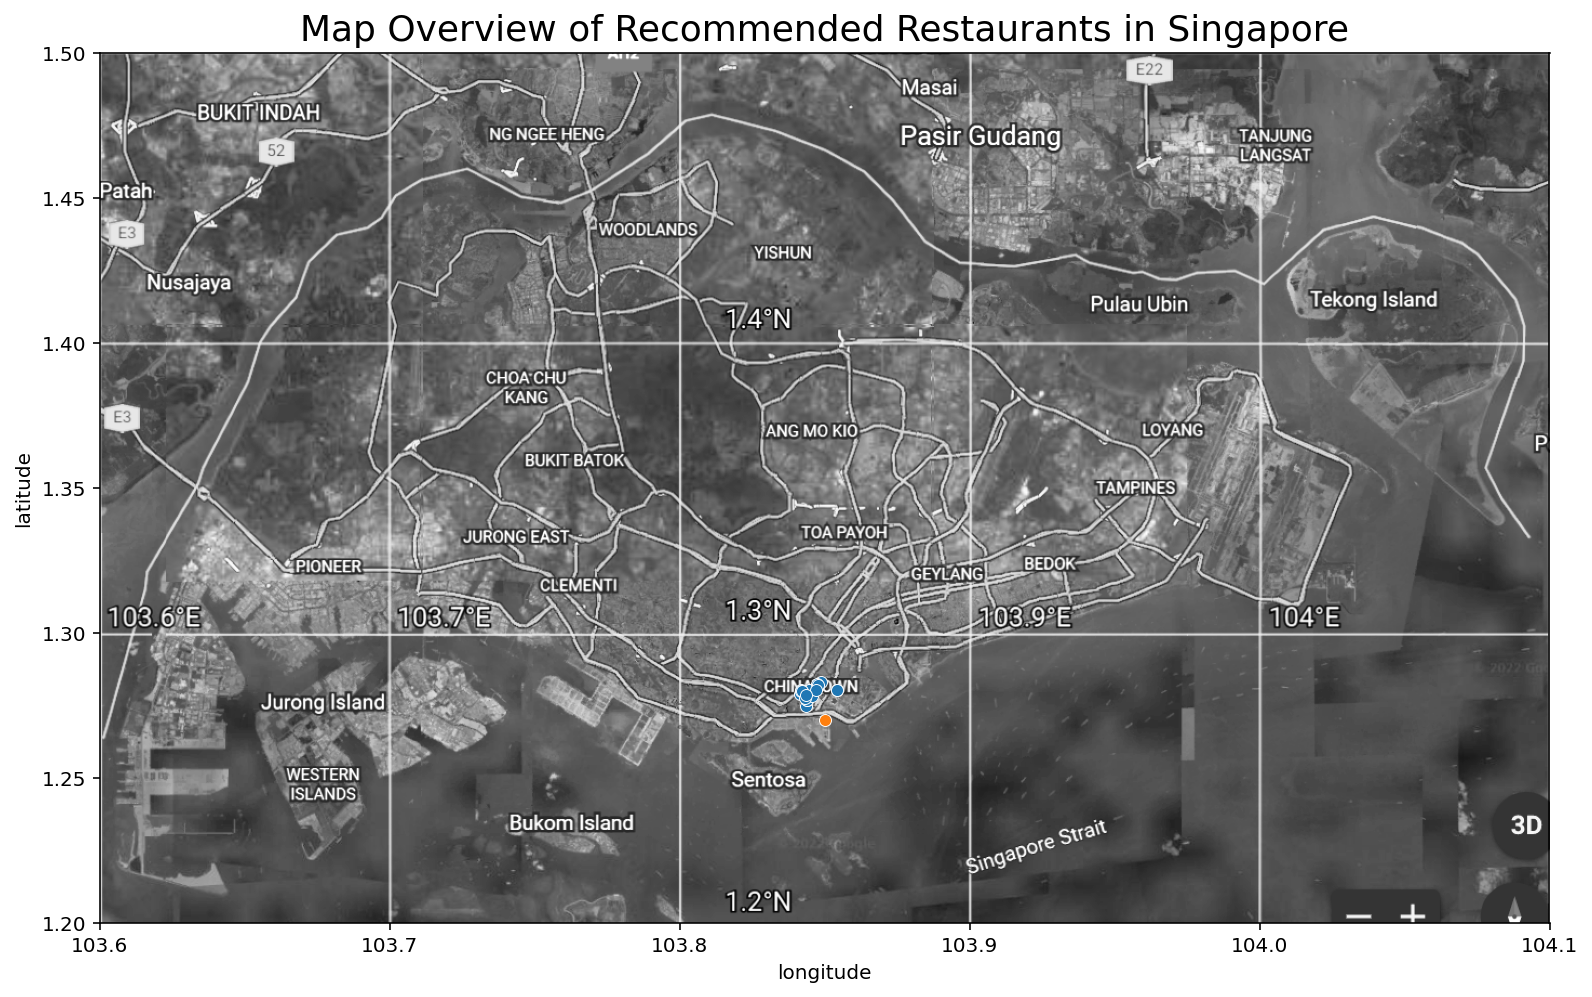

In [353]:
dist = 1.5
top_n = 20

plot_rest_map(rec_rest[rec_rest['dist_away']<dist].head(top_n), loc)
rec_rest[rec_rest['dist_away']<dist].head(top_n)

In [ ]:
# sparsity --> see how sparse the data is. calculate this. for the model. 

In [ ]:
# Problem statement: why is recommendation model important. before and after e commerce. limited inventory and mainstream product. with e-commerce not limited by inventory. recommend similar products to user become important. 

In [ ]:
# 

read up
1. matrix factorisation 
2. 

# <center> END OF NOTEBOOK </center>